# Bank Marketing

## Dataset Overview  
The **Bank Marketing Dataset** comes from a direct marketing campaign conducted by a Portuguese banking institution. The goal was to promote term deposits via phone calls. The dataset contains client-related attributes, campaign-related details, and socio-economic indicators. 

Source: https://archive.ics.uci.edu/dataset/222/bank+marketing

## Objective  
The primary objective of this analysis is to explore patterns in the data, perform feature engineering, and build predictive models to determine whether a client will subscribe to a term deposit (`y`).  

## Key Questions to Address
1. Develop a classification model with the variable “y” as the target.
    - [Perform an exploratory data analysis to uncover insights and identify the
    important variables.](#eda)
    - [What are the variables you included/excluded in the model? Briefly explain your
    reasoning for each variable.](#feature-selection)
    - [Briefly describe your model pipeline (e.g., pre-processing steps, chosen ML
    algorithms, etc.).](#pipeline)
    - [What is your chosen metric to describe the model performance? What is your
    reasoning behind it?](#results)
    - [Describe the model’s performance to a non-technical manager.](#results)
2. [Recommend a course of action to the credit team based on your analysis and model.
This may be as simple as a plan to target potential customers or as nuanced as
formulating a credit policy.](#eda)
3. [Optional: Share any additional insights or analyses that you may have from the data.](#eda)

# 1. Libraries and Configurations 

In [1]:
# Install the library where the dataset is stored
!pip3 install ucimlrepo -q

In [2]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn

# Libaries for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Libraries for modelling
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate, cross_val_predict

# Library containing the dataset
from ucimlrepo import fetch_ucirepo 

# Pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_colwidth', None)

# 2. Data Ingestion and Exploration

## 2.1 Fetching the Data

In [3]:
# Load the dataset
dataset = fetch_ucirepo(id=222)
df = dataset.data.original
df.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
25422,31,admin.,married,secondary,no,355,yes,no,cellular,18,nov,530,1,193,1,failure,no
20582,42,self-employed,married,secondary,no,487,yes,no,telephone,12,aug,58,4,-1,0,NaN,no
44460,33,student,married,secondary,no,1536,no,no,cellular,6,aug,258,2,178,4,success,yes
15552,59,retired,married,secondary,no,161,yes,no,cellular,21,jul,272,2,-1,0,NaN,no
24196,37,technician,married,secondary,no,421,yes,yes,cellular,17,nov,85,1,-1,0,NaN,no
15083,29,services,single,secondary,no,0,no,no,cellular,17,jul,58,1,-1,0,NaN,no
72,54,management,married,secondary,no,282,yes,yes,NaN,5,may,154,1,-1,0,NaN,no
11751,51,blue-collar,married,secondary,yes,0,no,yes,NaN,20,jun,179,3,-1,0,NaN,no
5210,35,admin.,married,secondary,no,2238,yes,no,NaN,23,may,42,3,-1,0,NaN,no
19467,41,technician,married,secondary,no,634,no,no,cellular,7,aug,122,2,-1,0,NaN,no


In [4]:
# Get the dataset description
dataset.variables[['name','description']]

,name,description
0,age,None
1,job,"type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"
2,marital,"marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"
3,education,"(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"
4,default,has credit in default?
5,balance,average yearly balance
6,housing,has housing loan?
7,loan,has personal loan?
8,contact,"contact communication type (categorical: 'cellular','telephone')"
9,day_of_week,last contact day of the week


### 2.1.1 Feature Descriptions
- `age`: Age of the client
- `job`: Job of the client
- `marital`: Marital status of the client
  - 'divorced' means divorced or widowed
- `education`: Education attainment of the client
- `default`: Whether the client has credit in default
- `balance`: Average yearly balance
- `housing`: Whether the client has a housing loan
- `loan`: Whether the client has a personal loan
- `contact`: Contact communication type
- `day_of_week`: Day of the week of last contact
- `month`: Month of last contact
- `duration`: Last contact duration
  - From the note, when `duration` is 0, then `y` is automatically no
  - Exlcude on predictive modelling due to this nature
- `campaign`: Number of contacts performed during this campaign for this client
  - Includes last contact
- `pdays`: Number of days that passed by after the client was last contacted from a previous campaign
  - -1 means client was not previously contacted
- `previous`: Number of contacts performed before this campaign and for this client	
- `poutcome`: Outcome of the previous marketing campaign
- `y`: Whether the client has subscribed to a term deposit, target variable for predictive modelling


## 2.2 Data Quality Check 

In [5]:
# Inspect the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Dataset contains 17 variables (16 features, 1 target), containing missing values for the columns: `job`, `education`, `contact`, `poutcome`

In [6]:
# Check for duplicates
df.duplicated().value_counts()

False    45211
Name: count, dtype: int64

No duplicates found

In [7]:
# Basic statistics - numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.000,40.936,10.619,18.000,33.000,39.000,48.000,95.000
balance,45211.000,1362.272,3044.766,-8019.000,72.000,448.000,1428.000,102127.000
day_of_week,45211.000,15.806,8.322,1.000,8.000,16.000,21.000,31.000
duration,45211.000,258.163,257.528,0.000,103.000,180.000,319.000,4918.000
campaign,45211.000,2.764,3.098,1.000,1.000,2.000,3.000,63.000
pdays,45211.000,40.198,100.129,-1.000,-1.000,-1.000,-1.000,871.000
previous,45211.000,0.580,2.303,0.000,0.000,0.000,0.000,275.000


Notable points from the statistics of numerical columns
- Some clients have negative balances (min: -8019)
- Skewed call duration, Q3 at 319, while max is at 4918
- Some clients were contacted up to 63 times, though most received only a few calls
- The value -1 dominates in `pdays`, indicating no prior contact for most clients
- Most clients had no prior campaign interactions, though some were contacted up to 275 times
- `day_of_week`, with minimum of 1 and maximum of 31, seems to be a day of the month instead

In [8]:
# Basic statistics - categorical columns
df.describe(include='object').T

,count,unique,top,freq
job,44923,11,blue-collar,9732
marital,45211,3,married,27214
education,43354,3,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,32191,2,cellular,29285
month,45211,12,may,13766
poutcome,8252,3,failure,4901
y,45211,2,no,39922


Notable points from the statistics of numerical columns
- The vast majority have no default history
- More than half have a housing loan, which might affect their likelihood of subscribing to a term deposit
- The most active month for marketing was May (13,766 calls)
- A large majority (39,922) did not subscribe to a term deposit, highlighting a class imbalance that needs to be addressed in modeling

<a id='eda'></a> 
## 2.3 Exploratory Data Analysis

1. *Perform an exploratory data analysis to uncover insights and identify the important variables*
   - Performed EDA for demographics, financial, and time-based variables (2.3.2 - 2.3.4)
2. *Recommend a course of action to the credit team based on your analysis and model.
This may be as simple as a plan to target potential customers or as nuanced as
formulating a credit policy.*
   - Recommendation is spread out throughtout the EDA
3. *Optional: Share any additional insights or analyses that you may have from the data.*
   - Additional analyses is also available in EDA section but doesn't really provide valuable insights

### 2.3.1 Data Cleaning in Preparation for EDA

In [9]:
# Inspect the data again
display(df.sample(5))
display(df.info())

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
4981,34,blue-collar,married,primary,no,218,yes,yes,NaN,21,may,260,1,-1,0,NaN,no
340,41,blue-collar,single,secondary,no,842,yes,no,NaN,5,may,144,3,-1,0,NaN,no
7834,27,technician,single,secondary,no,430,yes,yes,NaN,30,may,78,3,-1,0,NaN,no
29599,32,management,married,secondary,no,1215,yes,yes,cellular,3,feb,211,2,-1,0,NaN,no
35915,44,admin.,married,secondary,no,1248,yes,yes,cellular,8,may,428,3,-1,0,NaN,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


None

To make it more presentable in EDA, it is better to do the following:
- Make the categorical variable into a title format
- A period is present in the `job` column
- Convert month to it's full name
- Rename `day_of_week` to `day_of_month`
- Missing values in `job`, `education`, and `contact` should be imputed with 'Others' value
- Missing value in `poutcome` means that the client was not previously contacted (i.e., `pdays` == -1), fill with 'No Records' value

#### 2.3.1.1 Convert Categorical Columns to Title Format

In [10]:
# Turn all categorical variables into title format
categorical_columns = df.select_dtypes(include=['object']).columns
df_eda = df.copy()
df_eda[categorical_columns] = df_eda[categorical_columns].apply(lambda x: x.str.title())

# Display few rows to verify the changes
df_eda.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
35275,32,Blue-Collar,Married,Secondary,No,428,Yes,No,Cellular,7,May,93,1,363,1,Failure,No
38324,30,Blue-Collar,Married,Primary,No,714,Yes,No,Cellular,15,May,199,1,-1,0,NaN,No
45158,34,Student,Single,NaN,No,2321,No,No,Cellular,9,Nov,600,2,99,5,Failure,No
9078,37,Unemployed,Single,Primary,No,1648,Yes,No,NaN,5,Jun,166,2,-1,0,NaN,No
20064,34,Management,Married,Tertiary,No,1433,No,No,Cellular,8,Aug,170,3,-1,0,NaN,No
43517,31,Housemaid,Single,Primary,No,26965,No,No,Cellular,21,Apr,654,2,-1,0,NaN,Yes
19253,60,Retired,Married,Secondary,No,1145,No,No,Cellular,6,Aug,167,2,-1,0,NaN,No
25588,55,Technician,Married,Secondary,No,0,No,No,Cellular,19,Nov,336,1,-1,0,NaN,No
12247,36,Unemployed,Married,Tertiary,No,4145,No,No,NaN,20,Jun,988,4,-1,0,NaN,Yes
18458,57,Retired,Married,Secondary,No,1354,No,No,Cellular,31,Jul,131,9,-1,0,NaN,No


#### 2.3.1.2 Removing the period in `job`

In [11]:
# Removing the period in job column
df_eda['job'] = df_eda['job'].str.replace('.','')

# Display few rows to verify the changes
df_eda.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
19686,31,Blue-Collar,Married,Primary,No,196,No,No,Cellular,7,Aug,248,1,-1,0,NaN,No
99,46,Management,Married,Tertiary,No,229,Yes,No,NaN,5,May,197,1,-1,0,NaN,No
15364,44,Management,Married,Secondary,No,3286,Yes,No,Cellular,18,Jul,569,1,-1,0,NaN,No
19000,46,Management,Married,Tertiary,No,1720,No,No,Cellular,5,Aug,250,2,-1,0,NaN,No
36056,38,Blue-Collar,Married,Secondary,No,625,Yes,Yes,Cellular,11,May,210,1,-1,0,NaN,No
2283,29,Blue-Collar,Single,Secondary,No,16,No,No,NaN,12,May,197,3,-1,0,NaN,No
3678,40,Admin,Married,Secondary,No,2,Yes,No,NaN,16,May,29,1,-1,0,NaN,No
2116,40,Blue-Collar,Divorced,Primary,No,737,Yes,Yes,NaN,12,May,102,1,-1,0,NaN,No
9291,35,Blue-Collar,Married,Primary,No,3279,No,No,NaN,5,Jun,240,2,-1,0,NaN,No
2086,35,Self-Employed,Married,Tertiary,No,247,Yes,No,NaN,12,May,167,2,-1,0,NaN,No


#### 2.3.1.3 Renaming Values of `month` and the column name `day_of_week`

In [12]:
# Make a mapping of month abbreviations to full month names
month_map = {
    'Jan':'January', 
    'Feb':'February', 
    'Mar':'March', 
    'Apr':'April', 
    'May':'May', 
    'Jun':'June', 
    'Jul':'July', 
    'Aug':'August', 
    'Sep':'September', 
    'Oct':'October', 
    'Nov':'November', 
    'Dec':'December'
}

# Apply the mapping to the month column
df_eda['month'] = df_eda['month'].map(month_map)

# Display few rows to verify the changes
df_eda.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
27343,57,Management,Married,Tertiary,No,24498,No,No,Cellular,21,November,161,5,-1,0,NaN,No
4578,34,Blue-Collar,Single,Primary,No,709,Yes,No,NaN,20,May,106,1,-1,0,NaN,No
15576,41,Blue-Collar,Single,Secondary,No,98,No,Yes,Cellular,21,July,97,6,-1,0,NaN,No
13870,40,Blue-Collar,Single,Secondary,No,3571,Yes,No,Cellular,10,July,262,1,-1,0,NaN,No
44679,43,Technician,Married,Secondary,No,4945,Yes,No,Cellular,3,September,219,3,185,2,Success,Yes
10109,52,Retired,Married,NaN,No,293,No,No,NaN,11,June,706,1,-1,0,NaN,Yes
6568,34,Blue-Collar,Married,Primary,No,100,Yes,Yes,NaN,28,May,74,3,-1,0,NaN,No
6443,51,Blue-Collar,Divorced,Secondary,No,78,Yes,No,NaN,27,May,723,2,-1,0,NaN,No
23721,33,Technician,Married,Secondary,No,2,No,No,Cellular,28,August,385,7,-1,0,NaN,No
835,44,Technician,Divorced,Secondary,No,-329,Yes,No,NaN,7,May,171,1,-1,0,NaN,No


In [13]:
# Rename the `day_of_week` column to `day_of_month`
df_eda.rename(columns={'day_of_week':'day_of_month'}, inplace=True)

# Print column names to verify the changes
df_eda.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_month', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

#### 2.3.1.4 Handling Missing Values

In [14]:
# Fill NaN values in job, education, and contact columns with 'Unknown'
df_eda['job'] = df_eda['job'].fillna('Unknown')
df_eda['education'] = df_eda['education'].fillna('Unknown')
df_eda['contact'] = df_eda['contact'].fillna('Unknown')

# Display few rows to verify the changes
df_eda.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,duration,campaign,pdays,previous,poutcome,y
19036,51,Technician,Married,Secondary,No,-379,Yes,No,Cellular,5,August,261,1,-1,0,NaN,No
28906,66,Housemaid,Married,Secondary,No,1929,No,No,Cellular,2,February,169,1,-1,0,NaN,No
33849,68,Retired,Married,Secondary,No,20723,Yes,No,Cellular,28,April,318,2,-1,0,NaN,No
6291,29,Blue-Collar,Married,Primary,No,715,Yes,No,Unknown,27,May,170,1,-1,0,NaN,No
18543,35,Blue-Collar,Divorced,Primary,No,4401,Yes,No,Cellular,31,July,465,4,-1,0,NaN,No
2188,32,Blue-Collar,Married,Primary,No,1064,Yes,No,Unknown,12,May,326,1,-1,0,NaN,No
36937,31,Blue-Collar,Married,Primary,No,295,Yes,No,Cellular,12,May,235,6,-1,0,NaN,No
30667,52,Management,Divorced,Primary,No,11,No,No,Cellular,6,February,365,1,9,1,Other,No
5687,37,Admin,Single,Secondary,No,155,Yes,No,Unknown,26,May,460,1,-1,0,NaN,No
787,46,Management,Married,Tertiary,No,0,No,No,Unknown,7,May,70,2,-1,0,NaN,No


In [15]:
# Fill NaN values in poutcome column with 'No Records'
df_eda['poutcome'] = df_eda['poutcome'].fillna('No Records')

# Display few rows to verify the changes
df_eda.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,duration,campaign,pdays,previous,poutcome,y
45200,38,Technician,Married,Secondary,No,557,Yes,No,Cellular,16,November,1556,4,-1,0,No Records,Yes
22743,54,Housemaid,Married,Primary,No,182,No,No,Cellular,25,August,284,4,-1,0,No Records,No
5429,55,Technician,Married,Unknown,No,4746,Yes,No,Unknown,23,May,288,3,-1,0,No Records,No
26050,33,Management,Single,Tertiary,No,923,Yes,No,Cellular,19,November,1307,3,173,6,Failure,No
13359,34,Admin,Divorced,Secondary,No,145,No,No,Cellular,8,July,183,5,-1,0,No Records,No
19506,33,Technician,Single,Secondary,No,20,Yes,No,Cellular,7,August,131,2,-1,0,No Records,No
39713,54,Management,Divorced,Tertiary,No,55,Yes,No,Cellular,27,May,183,2,-1,0,No Records,No
10402,41,Services,Married,Secondary,No,-700,No,Yes,Unknown,12,June,309,1,-1,0,No Records,No
24251,54,Technician,Married,Secondary,No,465,Yes,Yes,Cellular,17,November,92,1,-1,0,No Records,No
31089,82,Retired,Married,Tertiary,No,278,No,No,Cellular,16,February,223,7,-1,0,No Records,No


### 2.3.2 Customer Demographics

#### 2.3.2.1 Age 

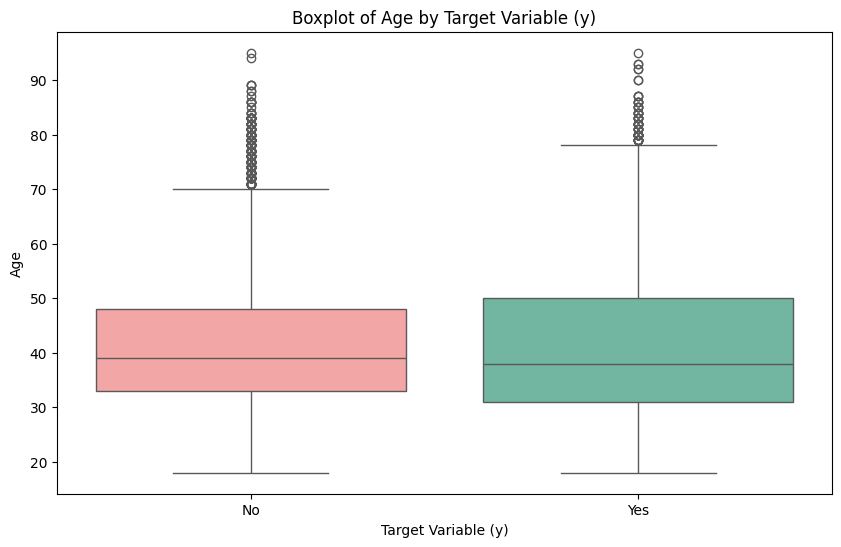

In [16]:
# Create a boxplot of age and y with a more presentable color scheme
plt.figure(figsize=(10, 6))
sns.boxplot(x='y', y='age', data=df_eda, palette={'Yes': '#66c2a5', 'No': '#ff9999'}, hue='y')
plt.title('Boxplot of Age by Target Variable (y)')
plt.xlabel('Target Variable (y)')
plt.ylabel('Age')
plt.show()

The **distribution of age** for both clients who subscribed or didn't subscribed are **more or less the same**. **Outliers are present** in the upper portion of both categories, with ages **above 60**.

#### 2.3.2.2 Marital Status

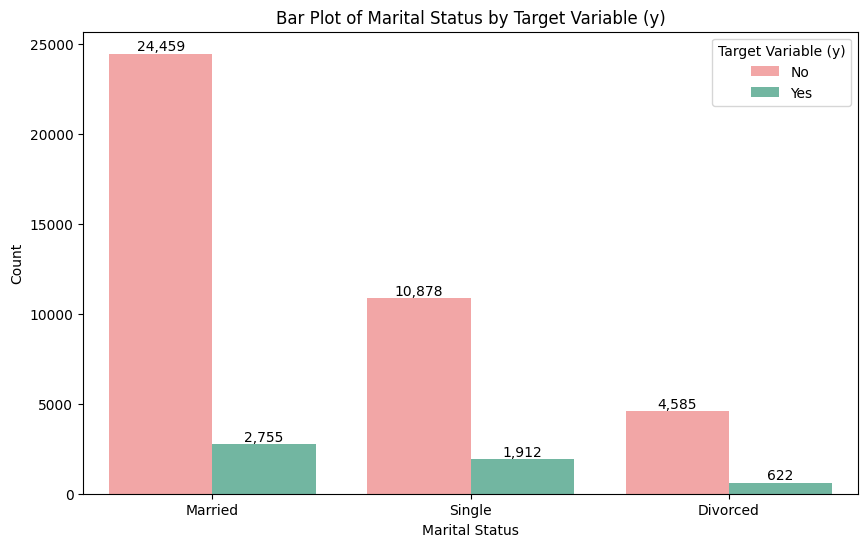

In [17]:
# Create a bar plot for marital status and y
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='marital', hue='y', data=df_eda, palette={'Yes': '#66c2a5', 'No': '#ff9999'})
plt.title('Bar Plot of Marital Status by Target Variable (y)')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Target Variable (y)')

# Annotate the actual numbers on the plot with commas for thousand places
for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(f'{height:,.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

**Majority** of the target clients for marketing are **Married**, as a result, there's also a **higher** number of people people who **subscribed** to the term deposit. However, it is also glaring that the **acceptance rate** for married people is also the **lowest**.

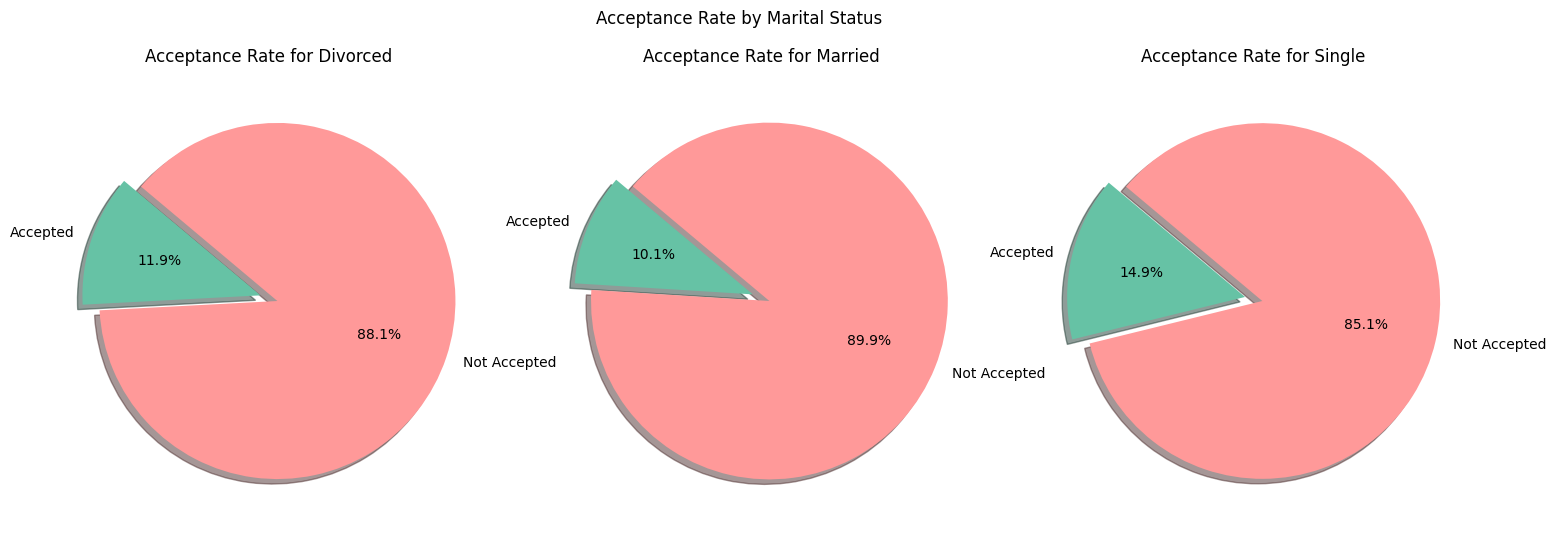

In [18]:
# Calculate the acceptance rate for each marital status category
acceptance_rate = df_eda[df_eda['y'] == 'Yes'].groupby('marital').size() / df_eda.groupby('marital').size()

# Create pie charts for each marital status category
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

marital_statuses = acceptance_rate.index
for i, marital_status in enumerate(marital_statuses):
    sizes = [acceptance_rate[marital_status], 1 - acceptance_rate[marital_status]]
    labels = ['Accepted', 'Not Accepted']
    colors = ['#66c2a5', '#ff9999']
    explode = (0.1, 0)  # explode the 1st slice (Accepted)
    
    axes[i].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                shadow=True, startangle=140)
    axes[i].axis('equal') 
    axes[i].set_title(f'Acceptance Rate for {marital_status.capitalize()}')

plt.suptitle('Acceptance Rate by Marital Status')
plt.show()

From the pie charts above, **Married** category has indeed the **lowest** acceptance rate. However, the **difference** from the lowest and the highest, which are the Single people, is **measly ~5%**. There might be **other factors** involved, given that the **average age** of client is around **40 years old**, and most of the people in that age are married.

Probable reason as to why **Single** people have **higher** acceptance rate is that they might have **less expenses** due to the nature of their lifestyle.
<br><br>
**Recommendation:** 
<br>
*Allocate more effort and resources toward Single individuals, considering their higher acceptance rate and potential financial flexibility*

#### 2.3.2.3 Job

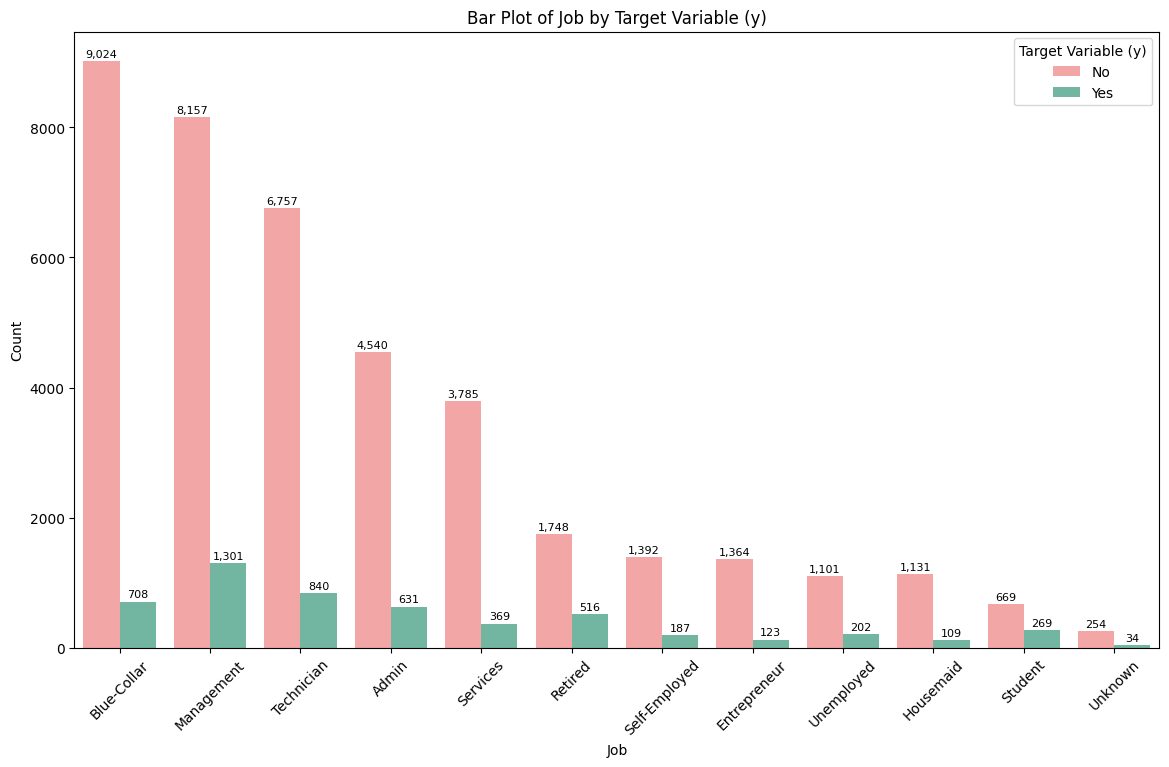

In [19]:
# Calculate the counts of each job category
job_counts = df_eda['job'].value_counts()

# Create a bar plot for job and y with jobs sorted by their counts
plt.figure(figsize=(14, 8))
ax = sns.countplot(x='job', hue='y', data=df_eda, palette={'Yes': '#66c2a5', 'No': '#ff9999'},
                   order=job_counts.index)
plt.title('Bar Plot of Job by Target Variable (y)')
plt.xlabel('Job')
plt.ylabel('Count')
plt.legend(title='Target Variable (y)')
plt.xticks(rotation=45)

# Annotate the actual numbers on the plot with commas for thousand places and smaller font size
for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(f'{height:,.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', 
                    fontsize=8)

plt.show()

Even though people with **Blue-Collar** jobs have **higher counts** in the data, in terms of people who have **subscribed** to the term deposit, it seems people in **Management** and **Technicians** is **higher**.

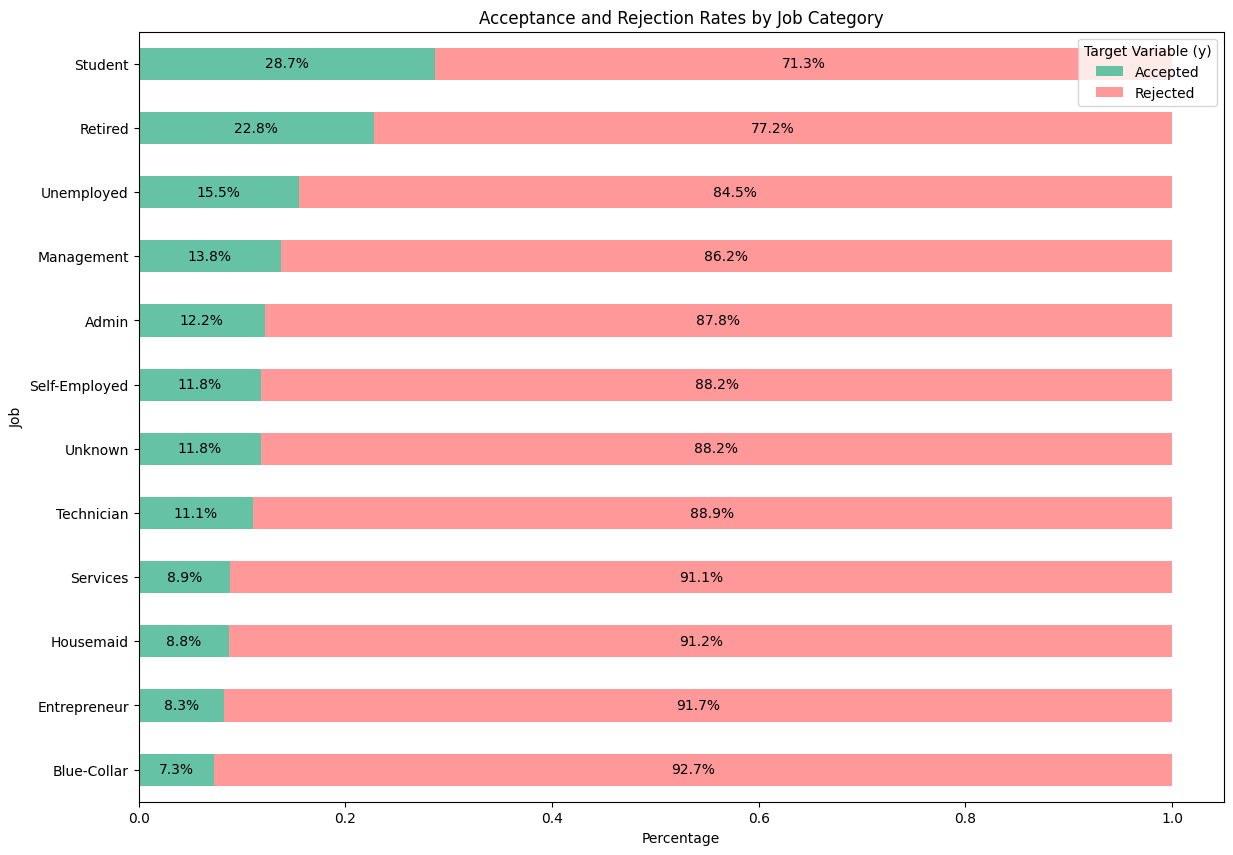

In [20]:
# Calculate the acceptance rate for each job category
acceptance_rate = df_eda[df_eda['y'] == 'Yes'].groupby('job').size() / df_eda.groupby('job').size()

# Calculate the rejection rate for each job category
rejection_rate = df_eda[df_eda['y'] == 'No'].groupby('job').size() / df_eda.groupby('job').size()

# Combine acceptance and rejection rates into a single DataFrame
rate_df = pd.DataFrame({'Accepted': acceptance_rate, 'Rejected': rejection_rate})

# Sort the job categories by acceptance rate
sorted_rate_df = rate_df.sort_values(by='Accepted', ascending=True)

# Create a horizontal bar plot for job and y with jobs sorted by acceptance rate
plt.figure(figsize=(14, 10))
sorted_rate_df.plot(kind='barh', stacked=True, color=['#66c2a5', '#ff9999'], ax=plt.gca())
plt.title('Acceptance and Rejection Rates by Job Category')
plt.xlabel('Percentage')
plt.ylabel('Job')
plt.legend(title='Target Variable (y)')

# Annotate the actual percentages on the plot
for i in range(len(sorted_rate_df)):
    accepted_rate = sorted_rate_df.iloc[i, 0]
    rejected_rate = sorted_rate_df.iloc[i, 1]
    if accepted_rate > 0:
        plt.text(accepted_rate / 2, i, f'{accepted_rate:.1%}', ha='center', va='center', fontsize=10, color='black')
    if rejected_rate > 0:
        plt.text(accepted_rate + rejected_rate / 2, i, f'{rejected_rate:.1%}', ha='center', va='center', fontsize=10, color='black')

plt.show()

The horizontal bar graph shows that **Students** have the highest acceptance rate at **28.7%**, followed by **Retired** individuals at **22.8%**, while **Blue-Collar** workers have the lowest acceptance rate at **7.3%**.

Recommendation:
<br>
*Target marketing efforts toward Students and Retired individuals, as they have the highest acceptance rates, and also towards people in Management field, as they have highest number of people who subscribed to the term deposity, while reassessing strategies for Blue-Collar workers who exhibit the lowest acceptance rate.*

#### 2.3.2.4 Educational Attainment

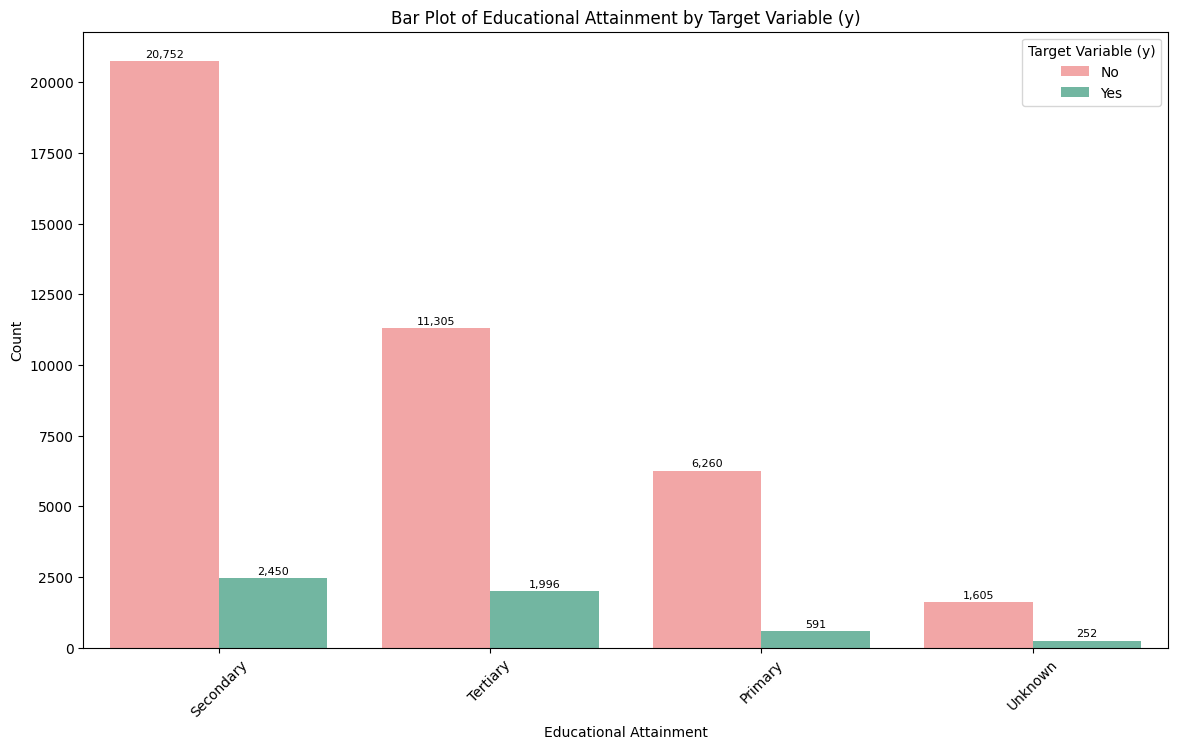

In [21]:
# Calculate the counts of each educational attainment category
educ_counts = df_eda['education'].value_counts()

# Create a bar plot for educational attainment and y with educational attainments sorted by their counts
plt.figure(figsize=(14, 8))
ax = sns.countplot(x='education', hue='y', data=df_eda, palette={'Yes': '#66c2a5', 'No': '#ff9999'},
                   order=educ_counts.index)
plt.title('Bar Plot of Educational Attainment by Target Variable (y)')
plt.xlabel('Educational Attainment')
plt.ylabel('Count')
plt.legend(title='Target Variable (y)')
plt.xticks(rotation=45)

# Annotate the actual numbers on the plot with commas for thousand places and smaller font size
for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(f'{height:,.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', 
                    fontsize=8)

plt.show()

Simply looking at the numbers, the categories with **higher count**, **consitently** possesses **higher people** who **accepted** the term deposit.

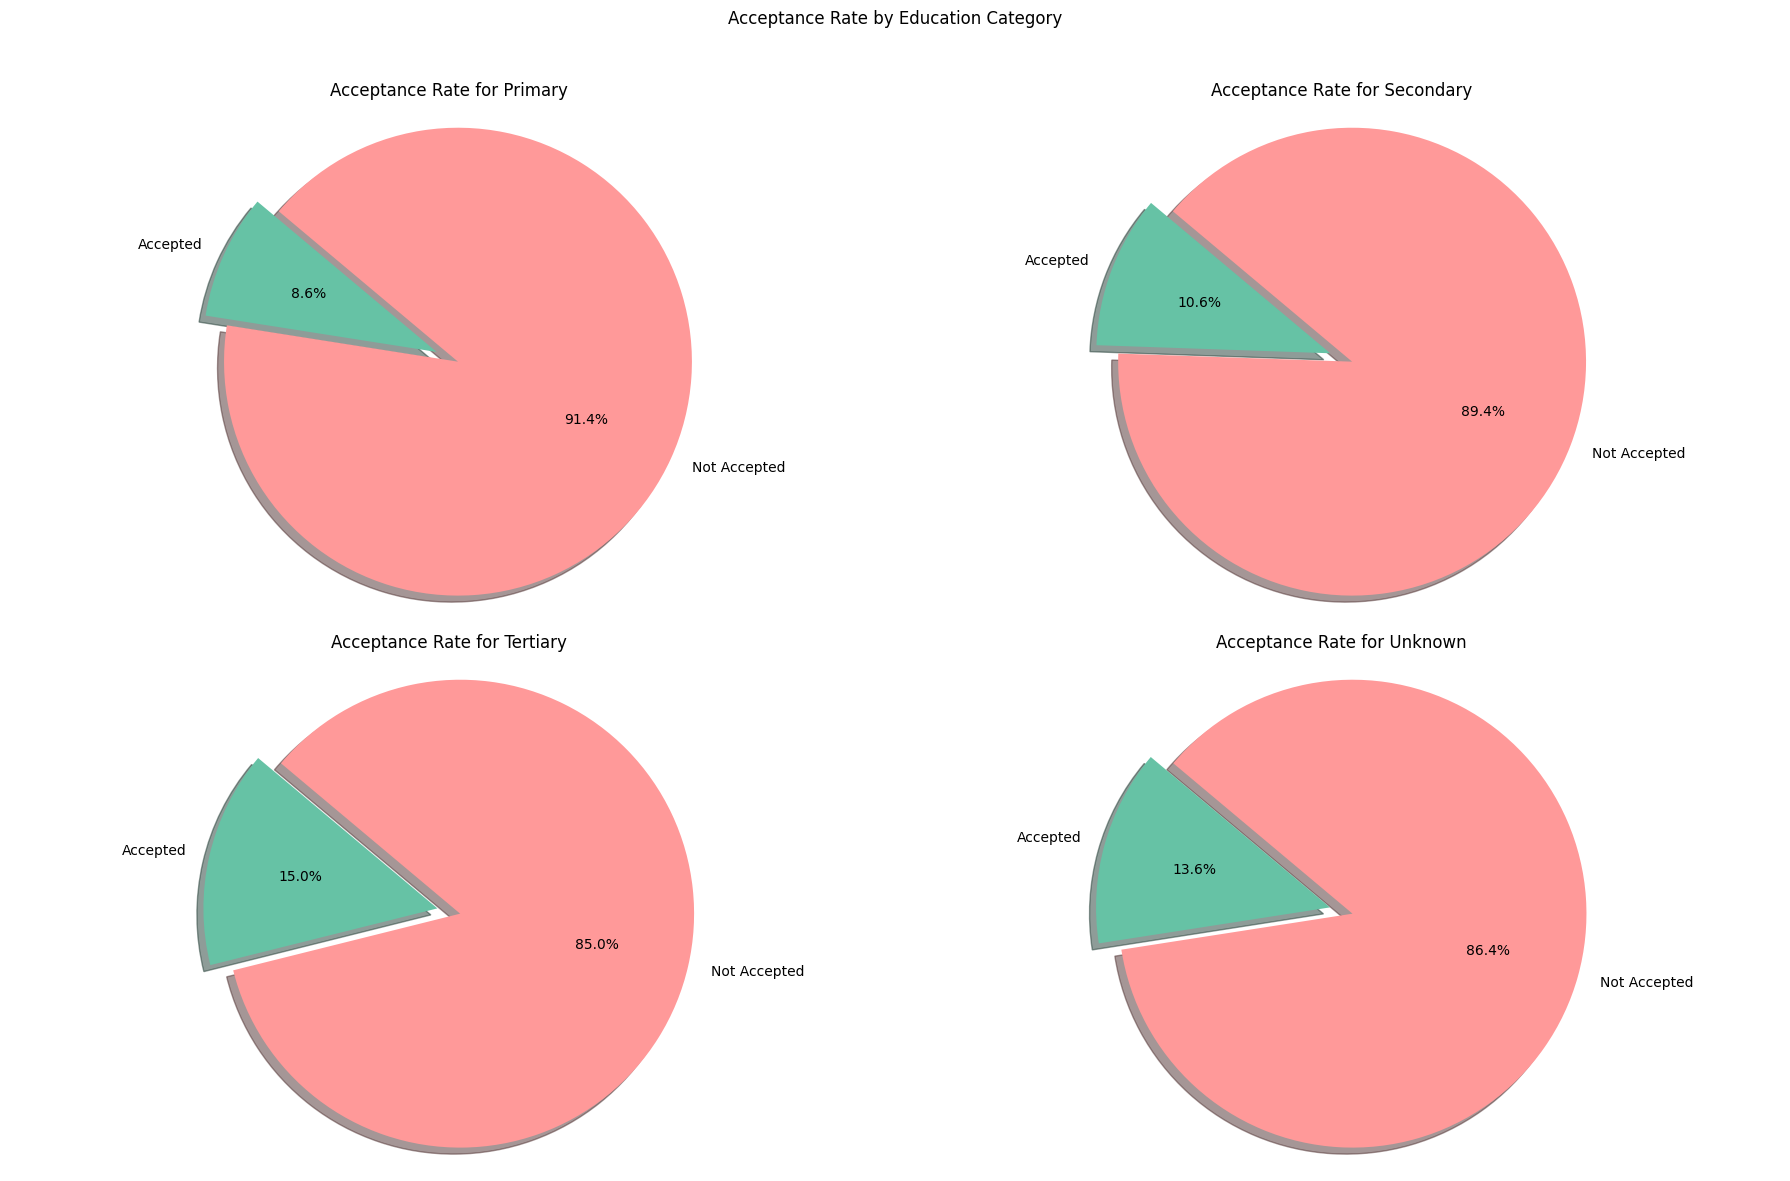

In [22]:
# Calculate the acceptance rate for each education category
acceptance_rate = df_eda[df_eda['y'] == 'Yes'].groupby('education').size() / df_eda.groupby('education').size()

# Create pie charts for each education category
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # Adjust the layout to fit all education categories

education_categories = acceptance_rate.index
for i, education in enumerate(education_categories):
    sizes = [acceptance_rate[education], 1 - acceptance_rate[education]]
    labels = ['Accepted', 'Not Accepted']
    colors = ['#66c2a5', '#ff9999']
    explode = (0.1, 0)  # explode the 1st slice (Accepted)
    
    ax = axes[i // 2, i % 2]  
    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
           shadow=True, startangle=140)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(f'Acceptance Rate for {education.capitalize()}')

plt.suptitle('Acceptance Rate by Education Category')
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

Even though people with **Secondary** educational attainment have **higher counts** within the data, people who finished **Tertiary** level actually seems to have **higher acceptance rate**.
<br><br>
Recommendation:
<br>
*Allocate more marketing effort and resources towards clients with Tertiary educational attainment, as they are more willing to say yes to the term deposit.*

### 2.3.3 Financial Attributes

#### 2.3.3.1 Balance

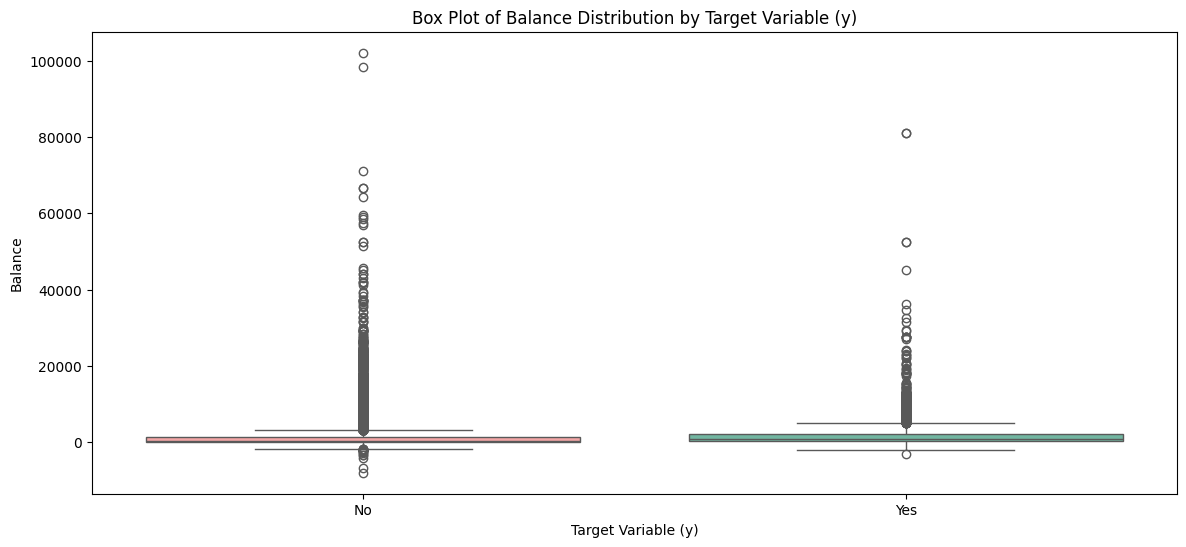

In [23]:
# Create a box plot for balance distribution for both people who said Yes and No to term deposit
plt.figure(figsize=(14, 6))

sns.boxplot(x='y', y='balance', data=df_eda, hue='y',palette={'Yes': '#66c2a5', 'No': '#ff9999'})
plt.title('Box Plot of Balance Distribution by Target Variable (y)')
plt.xlabel('Target Variable (y)')
plt.ylabel('Balance')
plt.show()


Due to the presence of outliers, we can't look closely to where majority of the balance are. Filter out clients with balance greater than 20,000.

In [24]:
def filter_outliers_iqr(df, column):
    """
    Filters out outliers from a DataFrame based on the IQR method for a specified column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column name for which to filter outliers.

    Returns:
    pd.DataFrame: The DataFrame with outliers removed.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for the specified column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the dataframe to exclude outliers
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

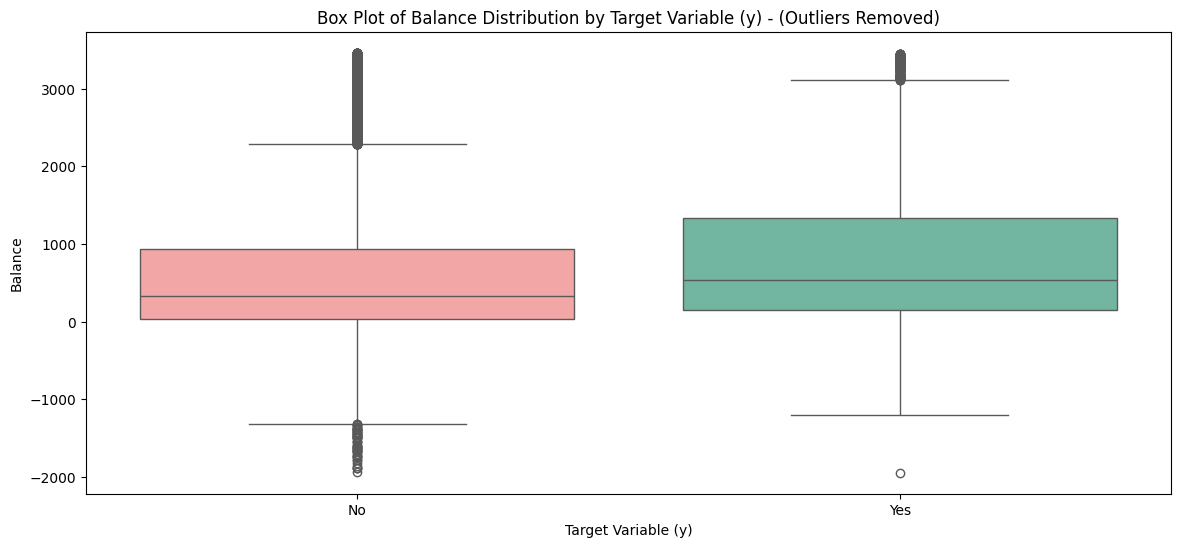

In [25]:
# Use the function to filter outliers in the 'balance' column
filtered_df = filter_outliers_iqr(df_eda, 'balance')

# Create a box plot for balance distribution for both people who said Yes and No to term deposit
plt.figure(figsize=(14, 6))
sns.boxplot(x='y', y='balance', data=filtered_df, hue='y', palette={'Yes': '#66c2a5', 'No': '#ff9999'})
plt.title('Box Plot of Balance Distribution by Target Variable (y) - (Outliers Removed)')
plt.xlabel('Target Variable (y)')
plt.ylabel('Balance')
plt.show()


In general, people who accepted the term deposit possesses a higher balance than those who don't

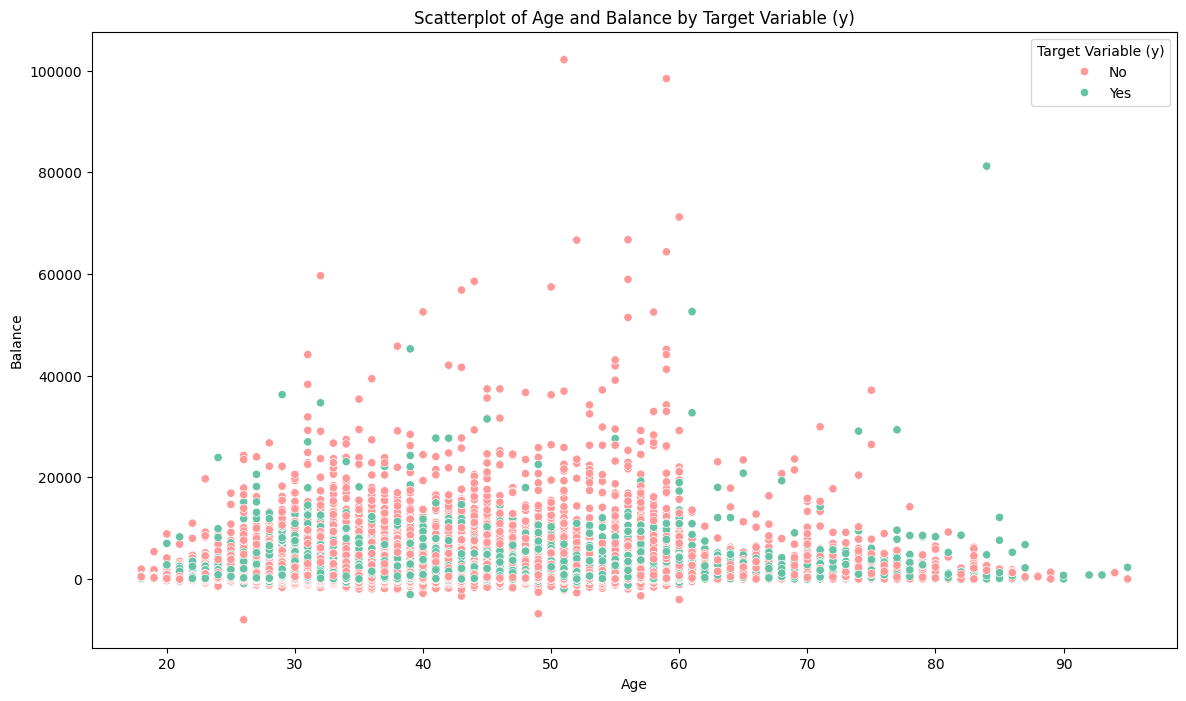

In [26]:
# Create a scatterplot of age and balance with hue as y
plt.figure(figsize=(14, 8))
sns.scatterplot(x='age', y='balance', hue='y', data=df_eda, palette={'Yes': '#66c2a5', 'No': '#ff9999'})
plt.title('Scatterplot of Age and Balance by Target Variable (y)')
plt.xlabel('Age')
plt.ylabel('Balance')
plt.legend(title='Target Variable (y)')
plt.show()

No distinct pattern can be observed from the scatterplot. The people who accepted the term deposit seems to be spread out thru the x and y axis.

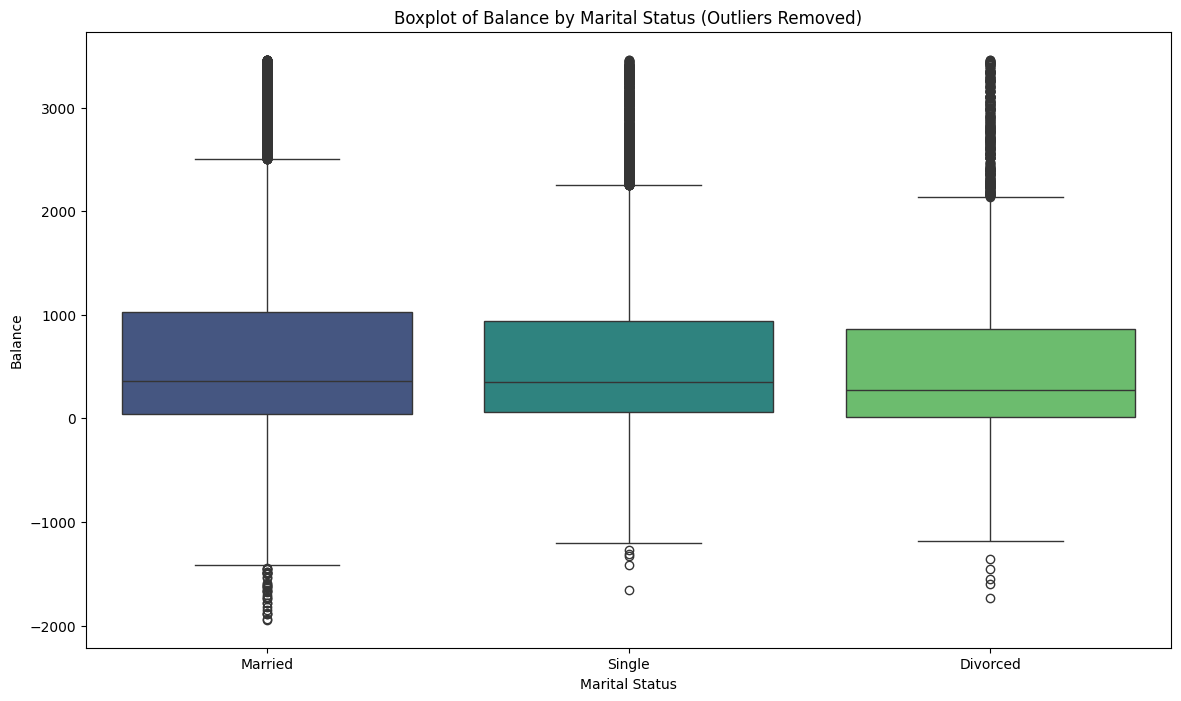

In [27]:
# Use the previously defined function to filter outliers in the 'balance' column
filtered_df = filter_outliers_iqr(df_eda, 'balance')

# Create a boxplot of balance and marital status with hue as y
plt.figure(figsize=(14, 8))
sns.boxplot(x='marital', y='balance', data=filtered_df, hue='marital', palette='viridis')
plt.title('Boxplot of Balance by Marital Status (Outliers Removed)')
plt.xlabel('Marital Status')
plt.ylabel('Balance')
plt.show()

The **distribution** per marital status is more or less **the same**, but it is quite noticeable that there's **more negative balance** for **Married** people. 

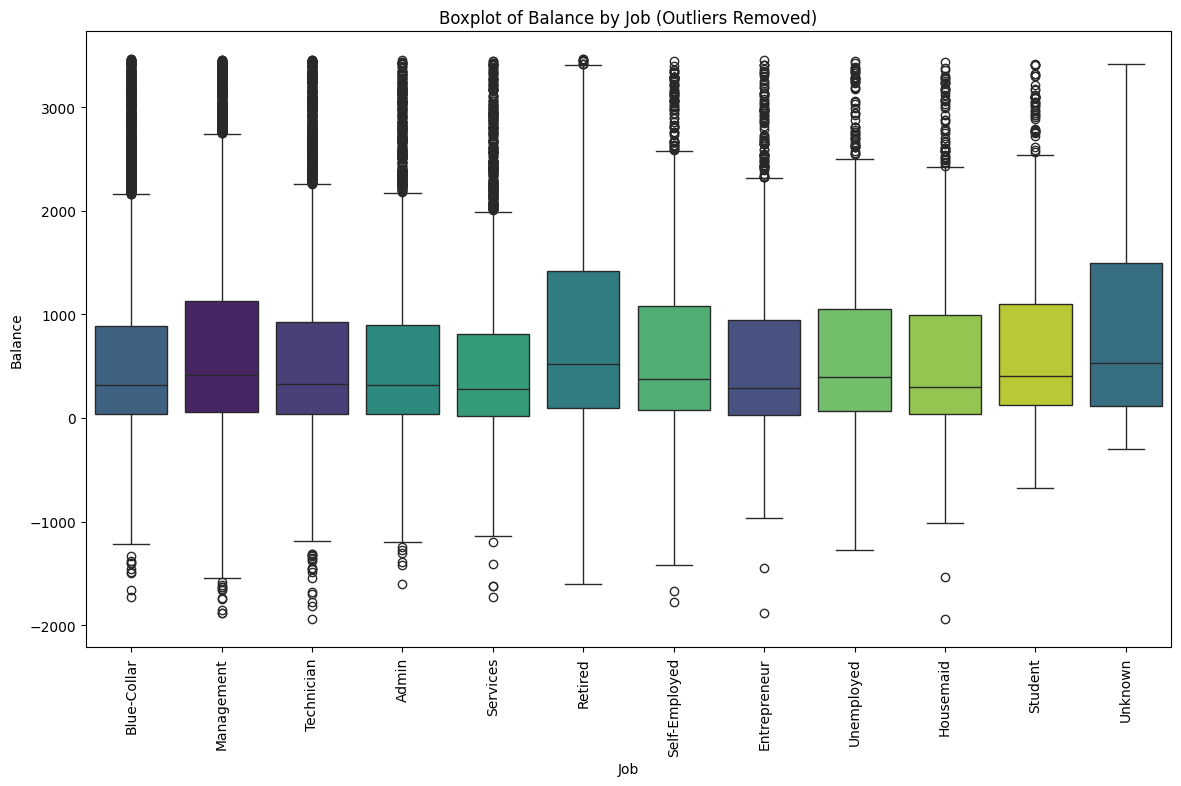

In [28]:
# Use the previously defined function to filter outliers in the 'balance' column
filtered_df = filter_outliers_iqr(df_eda, 'balance')

# Calculate the counts of each job category
job_counts = filtered_df['job'].value_counts()

# Create a boxplot of balance and job with jobs sorted by their counts
plt.figure(figsize=(14, 8))
sns.boxplot(x='job', y='balance', data=filtered_df, order=job_counts.index, hue='job', palette='viridis')
plt.title('Boxplot of Balance by Job (Outliers Removed)')
plt.xlabel('Job')
plt.ylabel('Balance')
plt.xticks(rotation=90)
plt.show()

Based on the target `job` categories from the previous analysis, people in **Management** and **Retired** individuas have noticeably higher average balance than most categories, while **Students** have similar distribution with other categories.

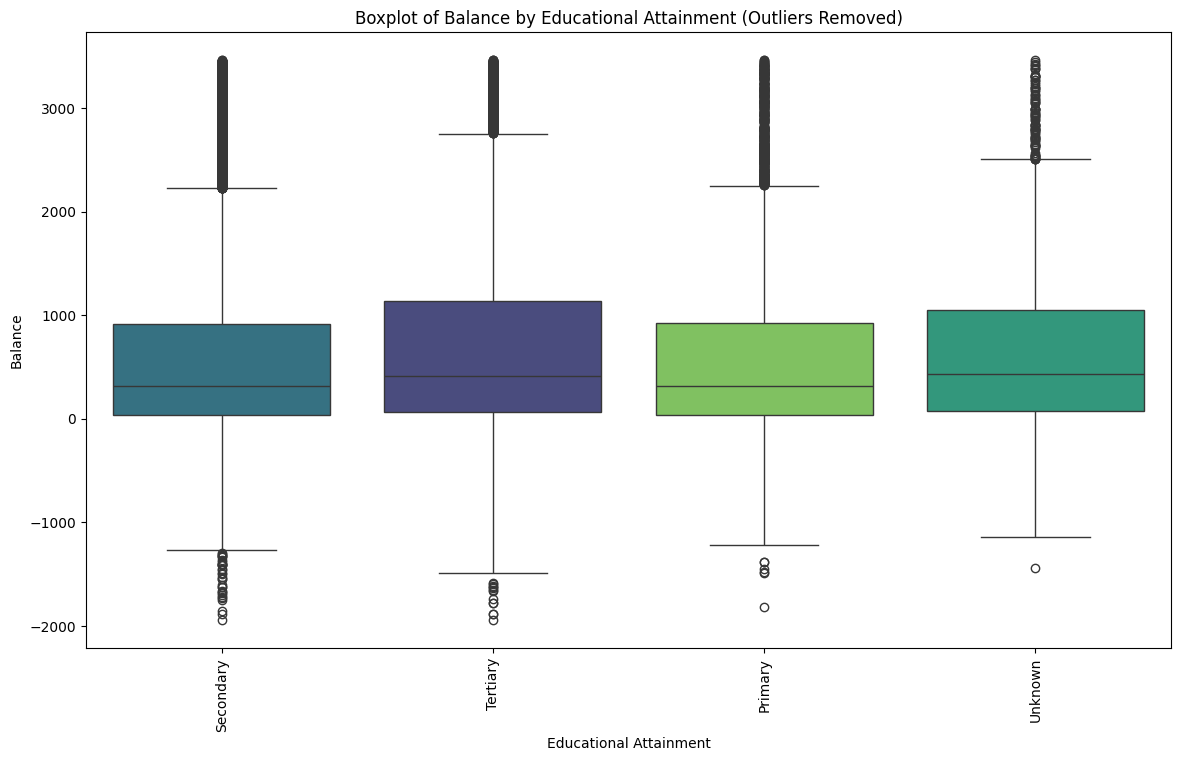

In [29]:
# Use the previously defined function to filter outliers in the 'balance' column
filtered_df = filter_outliers_iqr(df_eda, 'balance')

# Calculate the counts of each educational attainment category
education_counts = filtered_df['education'].value_counts()

# Create a boxplot of balance and education
plt.figure(figsize=(14, 8))
sns.boxplot(x='education', y='balance', data=filtered_df, order=education_counts.index, hue='education', palette='viridis')
plt.title('Boxplot of Balance by Educational Attainment (Outliers Removed)')
plt.xlabel('Educational Attainment')
plt.ylabel('Balance')
plt.xticks(rotation=90)
plt.show()

Aside from higher acceptance rate, people with **Tertiary** education also have a **higher balance** than other categories.

#### 2.3.3.2 Personal and Home Loans

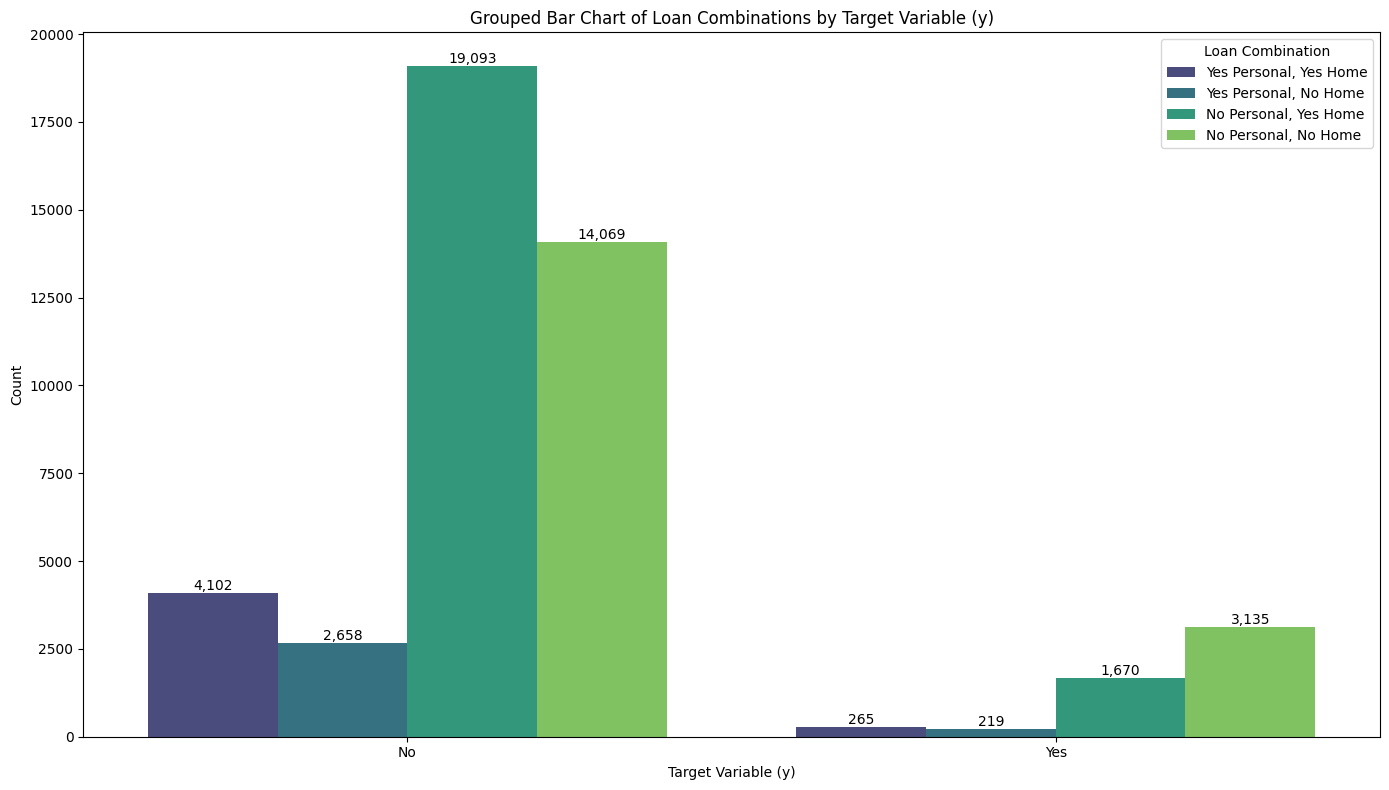

In [30]:
# Create a grouped bar chart for personal and home loans with y as y-axis
plt.figure(figsize=(14, 8))

# Create a new column to represent the combination of personal and home loans
df_eda['loan_combination'] = df_eda.apply(lambda row: f"{'Yes' if row['loan'] == 'Yes' else 'No'} Personal, {'Yes' if row['housing'] == 'Yes' else 'No'} Home", axis=1)

# Define the order of the loan combinations
order = ['Yes Personal, Yes Home', 'Yes Personal, No Home', 'No Personal, Yes Home', 'No Personal, No Home']

# Create a count plot for the loan combinations
ax = sns.countplot(x='y', hue='loan_combination', data=df_eda, palette='viridis', hue_order=order)
plt.title('Grouped Bar Chart of Loan Combinations by Target Variable (y)')
plt.xlabel('Target Variable (y)')
plt.ylabel('Count')

# Annotate the actual numbers on the plot
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:,.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.legend(title='Loan Combination', loc='upper right')
plt.tight_layout()
plt.show()

**Majority** of people who **subscribed** to the term deposit has **no personal/home loans**. On the other hand, most of the people who declined has at least a **home loan**.
<br><br>
Recommendation:
<br>
*Focus the marketing efforts and resources to people who doesn't have any kinds of loan.*

#### 2.3.3.3 Default

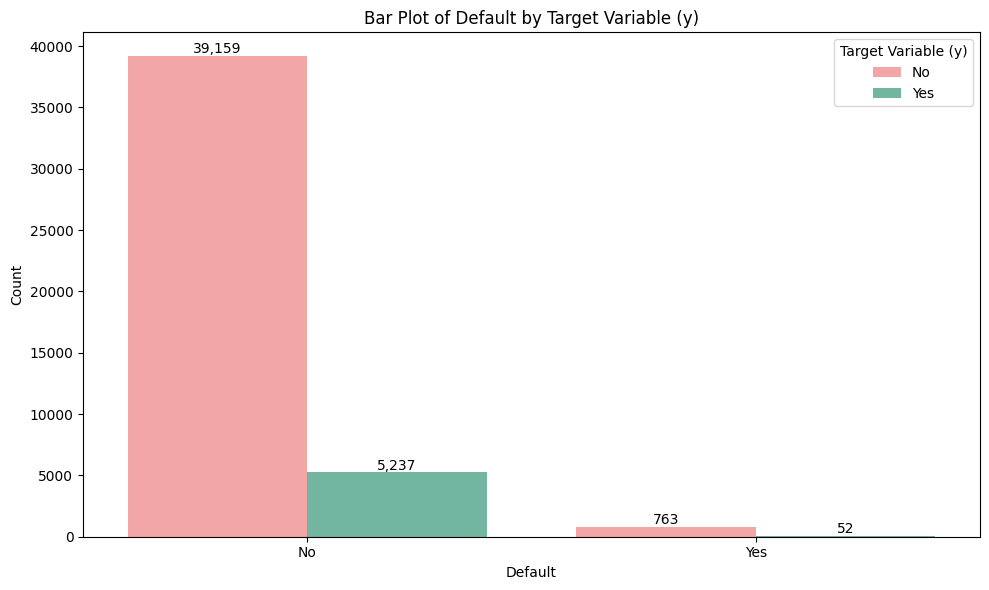

In [31]:
# Create a bar plot for default and y
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='default', hue='y', data=df_eda, palette={'Yes': '#66c2a5', 'No': '#ff9999'})
plt.title('Bar Plot of Default by Target Variable (y)')
plt.xlabel('Default')
plt.ylabel('Count')

# Annotate the actual numbers on the plot with commas for thousand places
for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(f'{height:,.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')


plt.legend(title='Target Variable (y)', loc='upper right')
plt.tight_layout()        
plt.show()

Only few people (~1%) with default subscribed to the term deposit, while the rest who accepted don't have a default.
<br><br>
Recommendation:
<br>
*Target people with no default in their credit*

### 2.3.4 Time-Based Patterns

#### 2.3.4.1 Month of Subscription

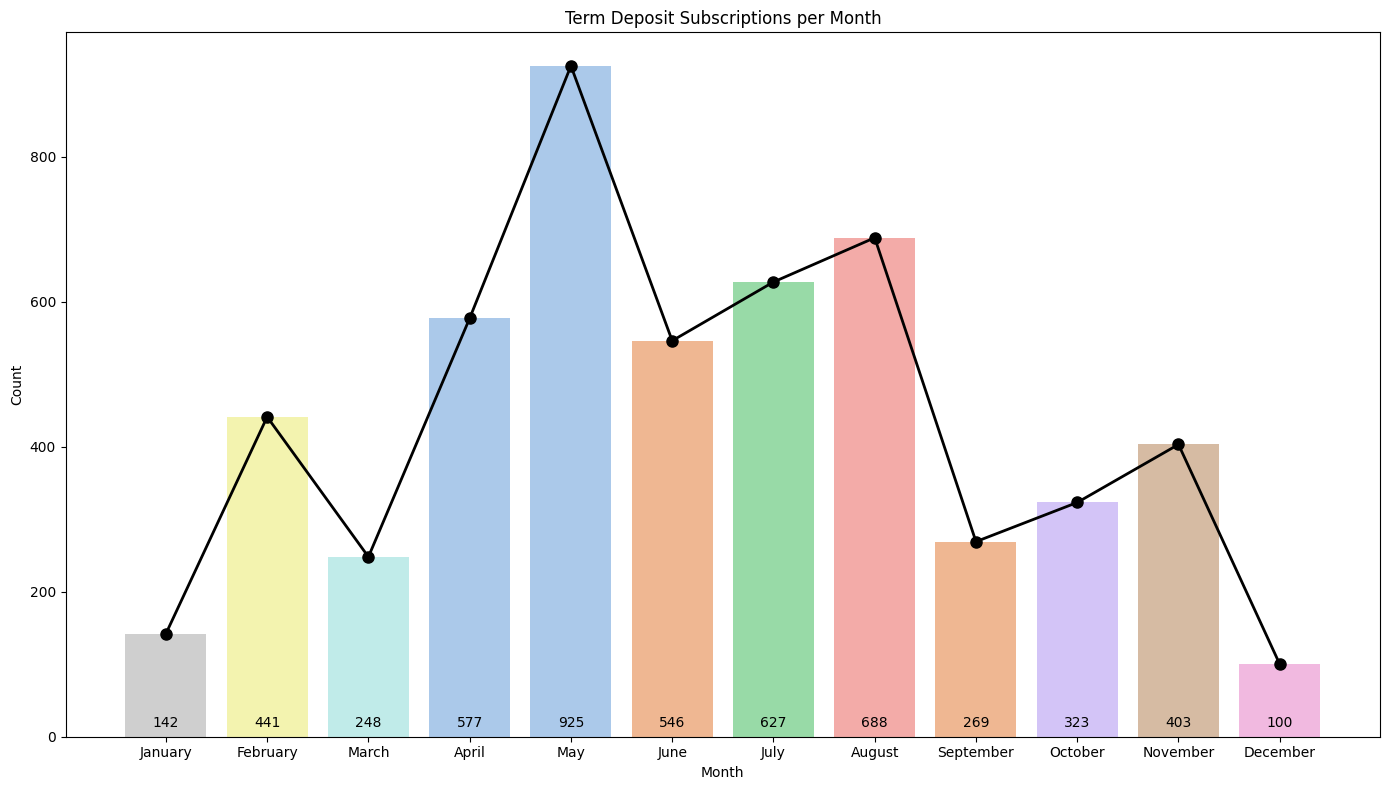

In [32]:
# Create a bar plot for people who subscribed to term deposit by month
plt.figure(figsize=(14, 8))
ax = sns.countplot(x='month', data=df_eda[df_eda['y'] == 'Yes'], order=month_map.values(), hue='month', palette='pastel')
plt.title('Term Deposit Subscriptions per Month')
plt.xlabel('Month')
plt.ylabel('Count')

# Add a line plot on top of the bars
monthly_counts = df_eda[df_eda['y'] == 'Yes']['month'].value_counts().reindex(month_map.values())
ax.plot(monthly_counts.index, monthly_counts.values, color='black', marker='o', linestyle='-', linewidth=2, markersize=8)

# Annotate the actual numbers on the plot with commas for thousand places
for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(f'{height:,.0f}', (p.get_x() + p.get_width() / 2., 0 + 10),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        
plt.tight_layout()
plt.show()

The subscription to the term deposit is **higher** on the period from **April to August** compared to other months, **peaking** at **May** with **925** subscriptions.

Recommendation: <br>
*Allocate more resources and efforts starting from April to August. For a more narrowed time frame, you can choose the top 3 months: May, August, and July.*

#### 2.3.4.2 Duration of Contact

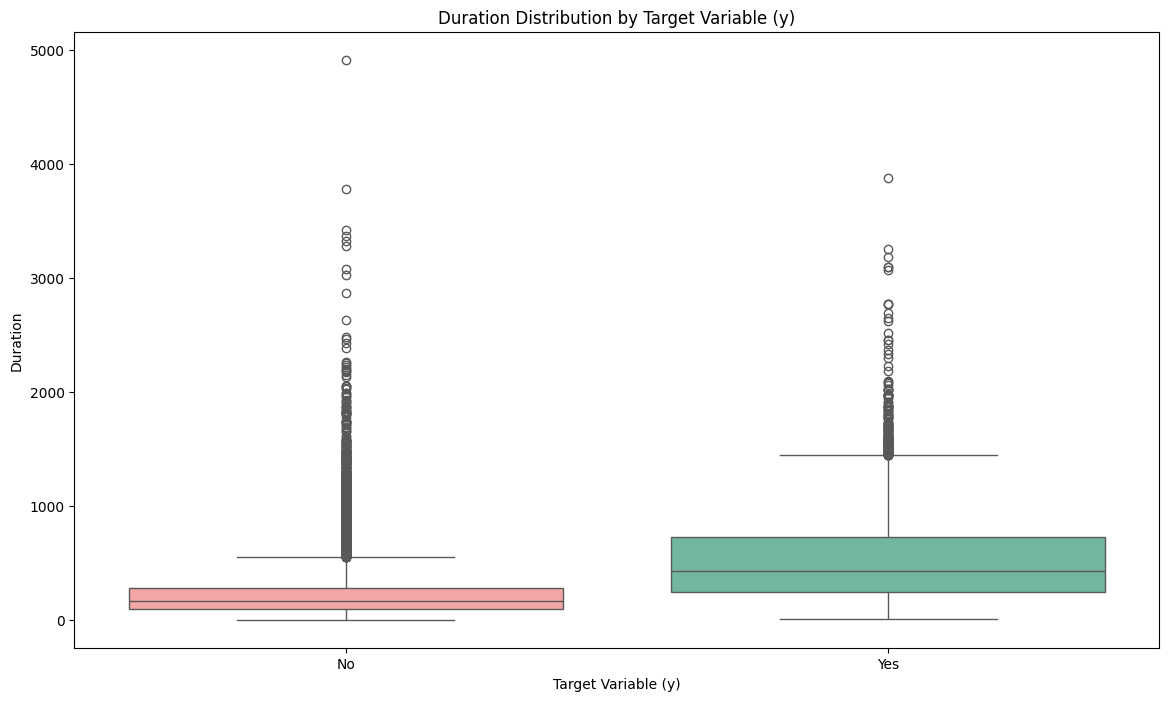

In [33]:
# Create a box plot for duration distribution for both people who said Yes and No to term deposit
plt.figure(figsize=(14, 8))
sns.boxplot(x='y', y='duration', data=df_eda[df_eda['duration'] != 0], hue='y', palette={'Yes': '#66c2a5', 'No': '#ff9999'})
plt.title('Duration Distribution by Target Variable (y)')
plt.xlabel('Target Variable (y)')
plt.ylabel('Duration')
plt.show()

From the distribution of `duration`, longer call are associated with a higher likelihood of subscription. These means that clients who doesn't have any interest in the term deposit would likely end the call faster.

# 3. Modelling

## 3.1 Data Preparation

<a id='feature-selection'></a> 
### 3.1.1 Features Selection

*What are the variables you included/excluded in the model? Briefly explain your reasoning for each variable.*

In [34]:
# Make a copy of the original DataFrame
df_preproc = df.copy()

Based from the data exploration done, the following are the features that is recommended to be dropped before modelling:
- `duration`: As noted in the dataset description, this a data that we won't know before we start calling the clients 
  - Drop
- `contact`: Value is could be cellular, landline, or NaN, which might not be a useful predictor 
  - Impute missing with 'unknown' and check the mutual information to `y`
- `poutcome`: Majority of the values is null (36,959/45,211), only entries are non-null
  - Impute missing with 'unknown' and check the mutual information to `y`
  - Also, closely related to `previous` and `pdays`, NaN in `poutcome` translates to 0 and -1 respectively
- `default`: Majority has no default history (44,396/45,211), which is highly imbalanced
  - Check the mutual information to `y`
- `day_of_week`: Transform to `day_of_month` again. Might not be as useful as `month`
  - Check the mutual information to `y`

In [35]:
# Impute all missing values to `unknown`
df_preproc['job'] = df_preproc['job'].fillna('unknown')
df_preproc['marital'] = df_preproc['marital'].fillna('unknown')
df_preproc['education'] = df_preproc['education'].fillna('unknown')
df_preproc['poutcome'] = df_preproc['poutcome'].fillna('unknown')

# Rename the `day_of_week` column to `day_of_month`
df_preproc.rename(columns={'day_of_week':'day_of_month'}, inplace=True)

# Drop the `duration` column
df_preproc.drop(columns='duration', inplace=True)

# Display few rows to verify the changes
df_preproc.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,campaign,pdays,previous,poutcome,y
42002,56,management,married,secondary,no,0,no,no,cellular,27,oct,1,111,8,other,yes
41556,32,management,single,tertiary,no,2,yes,no,cellular,11,sep,2,-1,0,unknown,yes
26361,50,blue-collar,married,primary,no,808,yes,no,cellular,20,nov,3,-1,0,unknown,no
11848,60,entrepreneur,married,secondary,no,1393,no,no,NaN,20,jun,6,-1,0,unknown,no
19183,31,management,single,tertiary,no,1377,no,no,cellular,5,aug,2,-1,0,unknown,no
30329,49,entrepreneur,divorced,secondary,no,32,no,no,cellular,5,feb,1,-1,0,unknown,no
11115,51,retired,married,primary,no,67,no,no,NaN,18,jun,1,-1,0,unknown,yes
22395,32,management,single,tertiary,no,334,no,no,cellular,22,aug,14,-1,0,unknown,no
43185,26,services,single,secondary,no,162,yes,no,cellular,2,mar,2,130,8,other,no
1288,26,student,single,secondary,no,85,yes,no,NaN,8,may,2,-1,0,unknown,no


In [36]:
# Use LabelEncoder to encode categorical variables
for column in df_preproc.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_preproc[column] = le.fit_transform(df_preproc[column])

# Display few rows to verify the changes
df_preproc.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,campaign,pdays,previous,poutcome,y
18228,35,10,1,3,0,144,0,0,0,30,5,3,-1,0,3,0
11400,53,10,0,1,0,4512,0,0,2,19,6,2,-1,0,3,0
27025,35,6,1,0,0,2086,1,0,0,21,9,7,-1,0,3,0
12641,57,5,1,1,0,156,0,1,2,4,5,2,-1,0,3,0
3182,58,4,1,2,0,44,1,0,2,15,8,2,-1,0,3,0
11065,42,1,1,0,0,46,1,0,2,17,6,6,-1,0,3,0
9411,35,6,2,0,0,45,0,1,2,6,6,1,-1,0,3,0
16236,45,0,1,1,0,295,1,0,0,23,5,1,-1,0,3,0
30752,47,7,0,1,0,691,0,0,0,6,3,6,-1,0,3,0
12729,34,6,1,2,0,-236,1,0,0,7,5,4,-1,0,3,0


Since this is a binary classification problem, use mutual information to measure the effectivity of each feature as predictors.

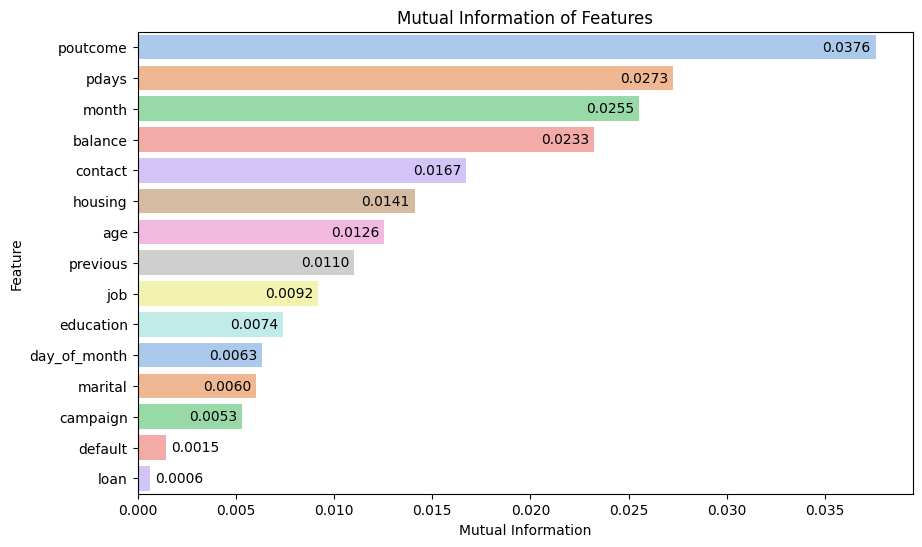

In [37]:
# Separate the features and target variable
X = df_preproc.drop(columns='y')
y = df_preproc['y']

# Calculate mutual information
mi = mutual_info_classif(X, y, discrete_features='auto', random_state=0)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plot mutual information
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Mutual Information', y='Feature', data=mi_df, hue='Feature', palette='pastel')
plt.title('Mutual Information of Features')

# Annotate the values beside the bars
for index, value in enumerate(mi_df['Mutual Information']):
    if value - 0.0025 > 0:
        plt.text(value - 0.0027, index, f'{value:.4f}', va='center')
    else:
        plt.text(value + 0.00025, index, f'{value:.4f}', va='center')

plt.show()

Drop `default` and `loan` column.

In [38]:
# Drop `default` and `loan` columns
df_preproc.drop(columns=['default', 'loan'], inplace=True)

Inspect data leakage through correlation matrix

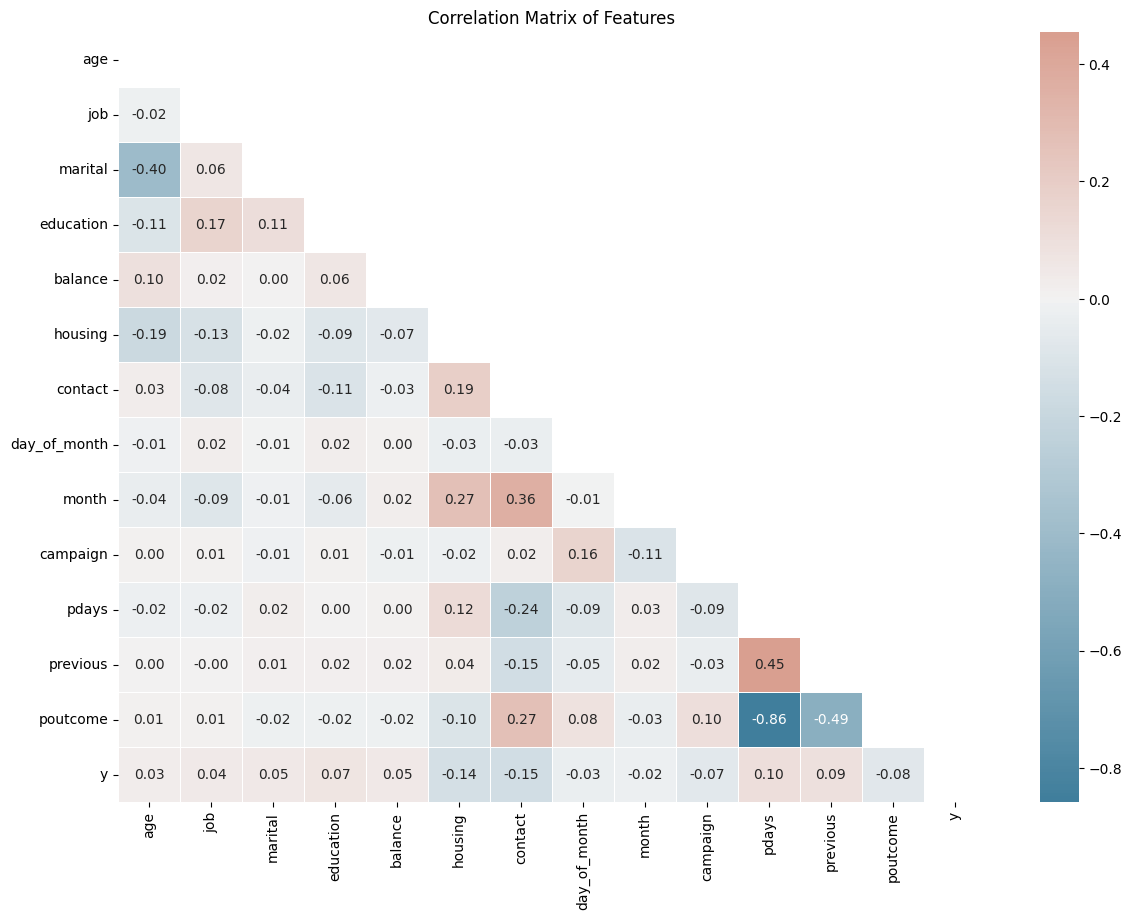

In [39]:
# Extract correlation matrix
corr_matrix = df_preproc.corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a custom diverging color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f", center=0, linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

Data leakage detected between `pdays` and `poutcome`. Drop `poutcome` since it has a high number of null values.

In [40]:
# Drop `poutcome` column
df_preproc.drop(columns='poutcome', inplace=True)

In [41]:
# Final list of retained columns
retained_columns = [x for x in df_preproc.columns if x != 'y']
print("Columns retained:")
for column in retained_columns:
    print(f"- {column}")

Columns retained:
- age
- job
- marital
- education
- balance
- housing
- contact
- day_of_month
- month
- campaign
- pdays
- previous


Dropped columns:
- `duration` - dropped based on dataset description
- `default` - low score on mutual information to the target variable
- `loan` - low score on mutual information to the target variable
- `poutcome` - possible data leakage

### 3.1.2 Train-Test Split

In [42]:
# Separate the features and target variable
X = df_preproc.drop(columns='y')
y = df_preproc['y']

# Inspect the distribution of the target variable
y.value_counts(normalize=True)

y
0   0.883
1   0.117
Name: proportion, dtype: float64

In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((36168, 12), (9043, 12), (36168,), (9043,))

In [44]:
# Inspect the distribution of the target variable in the training set and testing set
print('Training Set:')
display(y_train.value_counts(normalize=True))
print('Testing Set:')
display(y_test.value_counts(normalize=True))

Training Set:


y
0   0.883
1   0.117
Name: proportion, dtype: float64

Testing Set:


y
0   0.883
1   0.117
Name: proportion, dtype: float64

### 3.1.3 Oversampling

From the data inspection in earlier portion, there seems to be a class imbalance in the target variable

Oversample using SMOTE algorithm

In [45]:
# Oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# Display the shapes of the training set after oversampling
X_train_over.shape, y_train_over.shape

((63874, 12), (63874,))

<a id='pipeline'></a> 
## 3.2 Building the Model

*Briefly describe your model pipeline (e.g., pre-processing steps, chosen ML algorithms, etc.).*

**Preprocessing**
- **SMOTE** (Oversampling Algorithm) - due to class imbalance of the target variable
- Numeric Variables - excluded the imputer step as there's no missing values for numeric variables
  - **Standard Scaler** - normalize the numerical features into the same scale
- Categorical Variables - this was done before oversampling to use SMOTE algorithm
  - **Label Encoder** - turn categorical values to numerical
  - **Simple Imputer** - fill missing values with 'unknown'

**Modelling**
1. **Logistic Regression**: Simplest classifier algorithm for baseline 
2. **Decision Tree**: Captures non-linear relationships and provides explainability by visualizing decision paths 
3. **K-Nearest Neighbors (KNN)**: A non-parametric model that performs well in low-dimensional spaces and can capture complex decision boundaries
4. **Random Forest**: An ensemble method that reduces overfitting of decision trees by averaging multiple trees
5. **XGBoost**: A gradient boosting model that handles non-linearity, missing data, and imbalanced datasets efficiently

These 5 models are trained with the oversampled data, and the best performing across the basic metrics for classification is Random Forest Classifier.

Last step is tuning the hyperparameters of the chosen algorithm using **Bayes Search**.

### 3.2.1 Preprocessing Pipeline

Preprocessing of the categorical columns has already been accomplished prior to Oversampling, since SMOTE algorithm only accepts numerical variables.

In [46]:
# Define the preprocessing for numeric features
numeric_features = df.rename(columns={'day_of_week':'day_of_month'}) \
    .drop(['duration', 'default', 'loan', 'poutcome', 'y'], axis=1) \
    .select_dtypes(include='number').columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the preprocessing for categorical features
# NOTE: Preprocessing for categorical features is accomplished prior to oversampling - COMMENTED OUT
categorical_features = df.rename(columns={'day_of_week':'day_of_month'}) \
    .drop(['duration', 'default', 'loan', 'poutcome', 'y'], axis=1) \
    .select_dtypes(exclude='number').columns
categorical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    # ('encoder', LabelEncoder(handle_unknown='ignore'))
    ('pass', 'passthrough')
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['age', 'balance', 'day_of_month', 'campaign', 'pdays', 'previous'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('pass', 'passthrough')]),
                                 Index(['job', 'marital', 'education', 'housing', 'contact', 'month'], dtype='object'))])

### 3.2.2 Choosing the Best Model

In [47]:
# List of models to evaluate
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

In [48]:
# Function that evaluates the models using cross-validation and stratified sampling
def evaluate_models(models, preprocessor, X_train, y_train):
    """
    Evaluates multiple machine learning models using accuracy, precision, recall, F1 score, ROC AUC, and PR AUC.

    Parameters:
    models (dict): A dictionary where keys are model names and values are instantiated classifiers.
    preprocessor (ColumnTransformer): A preprocessing pipeline that applies transformations to numerical and categorical features.
    X_train (pd.DataFrame): The training feature set.
    y_train (pd.Series): The training target labels.

    Returns:
    pd.DataFrame: A DataFrame containing evaluation metrics (Accuracy, Precision, Recall, F1 Score, ROC AUC, and PR AUC) for each model.
    """
    results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in tqdm(models.items()):
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        roc_auc_scores = []
        pr_auc_scores = []

        for train_index, val_index in skf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # Create a pipeline with preprocessing and the model
            clf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', model)])
            
            # Fit the model
            clf.fit(X_train_fold, y_train_fold)

            # Make predictions
            y_pred = clf.predict(X_val_fold)
            y_pred_proba = clf.predict_proba(X_val_fold)[:, 1]

            # Calculate evaluation metrics
            accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
            precision_scores.append(precision_score(y_val_fold, y_pred))
            recall_scores.append(recall_score(y_val_fold, y_pred))
            f1_scores.append(f1_score(y_val_fold, y_pred))
            roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred_proba))
            pr_auc_scores.append(average_precision_score(y_val_fold, y_pred_proba))

        # Append the average results to the list
        results.append({
            'Model': name,
            'Accuracy': np.mean(accuracy_scores),
            'Precision': np.mean(precision_scores),
            'Recall': np.mean(recall_scores),
            'F1 Score': np.mean(f1_scores),
            'ROC AUC': np.mean(roc_auc_scores),
            'PR AUC': np.mean(pr_auc_scores)
        })

    return pd.DataFrame(results)

In [49]:
# Evaluate the models in original training set
evaluate_models(models, preprocessor, X_train, y_train)

100%|██████████| 5/5 [00:29<00:00,  5.87s/it]


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,LogisticRegression,0.882,0.265,0.003,0.006,0.713,0.262
1,DecisionTree,0.824,0.275,0.308,0.290,0.600,0.166
2,KNeighbors,0.881,0.481,0.168,0.248,0.679,0.248
3,RandomForest,0.887,0.553,0.166,0.255,0.771,0.376
4,XGBoost,0.888,0.550,0.228,0.322,0.776,0.394


From the results, it seems that the performance is good in terms of accuracy, but since we're dealing with imbalance dataset, accuracy is really not a good metric. In terms of other metrics, the models are not performing well.

In [50]:
# Evaluate the models in oversampled training set
evaluate_models(models, preprocessor, X_train_over, y_train_over)

100%|██████████| 5/5 [00:54<00:00, 10.81s/it]


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,LogisticRegression,0.746,0.728,0.784,0.755,0.818,0.801
1,DecisionTree,0.841,0.827,0.862,0.844,0.841,0.782
2,KNeighbors,0.852,0.849,0.855,0.852,0.914,0.892
3,RandomForest,0.901,0.895,0.908,0.901,0.959,0.962
4,XGBoost,0.880,0.891,0.866,0.878,0.946,0.950


For the default setup of the models, Random Forest Classifier seems to be the best model across all classification metrics.

### 3.2.3 Hyperparameter Tuning

In [51]:
# Define the parameter grid for BayesSearchCV
param_grid_rf = {
    'classifier__n_estimators': Integer(1, 20),  
    'classifier__max_depth': Integer(1, 10), 
    'classifier__min_samples_split': Integer(2, 10),
    'classifier__min_samples_leaf': Integer(1, 4),
    'classifier__max_features': Categorical(['sqrt', 'log2']),
    'classifier__bootstrap': Categorical([True, False]),
    'classifier__class_weight': Categorical(['balanced', 'balanced_subsample', None]),
    'classifier__criterion': Categorical(['gini', 'entropy'])
}

# Initialize the RandomForestClassifier
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

# Set up the StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=param_grid_rf,
    n_iter=20,
    scoring='average_precision',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit BayesSearchCV
bayes_search.fit(X_train_over, y_train_over)

# Get the best parameters and best score
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_
best_model = bayes_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [52]:
# Print best parameters and best score
print('Best Parameters:')
for param, value in best_params.items():
    print(f'{param.replace("classifier__","")}: {value}')
print(f'\nBest Score: {best_score}')

Best Parameters:
bootstrap: False
class_weight: balanced_subsample
criterion: entropy
max_depth: 10
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 20

Best Score: 0.9009659232613945


In [53]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'balance', 'day_of_month', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('pass',
                                                                   'passthrough')]),
                                                  Index(['job', 'marital', 'education', 'housing', 'contact', 'month'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=10,
                                        n_estimators=20))])

<a id='results'></a>
## 3.3 Evaluation of the Model's Performance

1. *What is your chosen metric to describe the model performance? What is your reasoning behind it?*
   - Main Metric:
     - **Precision-Recall - Area Under the Curve (PR AUC)**: This metric focuses on how well the model captures the positive class, ignoring the vast number of true negatives. A high PR AUC means the model can identify potential customers effectively. Trade-off between Precision and Recall.
   - Other metrics to consider:
     - **Precision**: If the bank wants to avoid wasting resources on uninterested customers, precision should be prioritized. High precision ensures that most customers the model predicts as "likely to subscribe" actually do subscribe.
     - **Recall**: If the goal is to maximize the number of correctly identified potential customers (even if it includes some false positives), recall is preferable. 
2. *Describe the model’s performance to a non-technical manager.*

### 3.3.1 Score in Evaluation Metrics

In [54]:
# Train the model with the best parameters on the entire training set
best_model.fit(X_train_over, y_train_over)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'balance', 'day_of_month', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('pass',
                                                                   'passthrough')]),
                                                  Index(['job', 'marital', 'education', 'housing', 'contact', 'month'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=10,
                                        n_estimators=20))])

In [55]:
# Initialize a dictionary to store the results
results = {}

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
y_pred_cv = cross_val_predict(best_model, X_train_over, y_train_over, cv=skf, method='predict')
y_pred_proba_cv = cross_val_predict(best_model, X_train_over, y_train_over, cv=skf, method='predict_proba')[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_train_over, y_pred_cv)
precision = precision_score(y_train_over, y_pred_cv)
recall = recall_score(y_train_over, y_pred_cv)
f1 = f1_score(y_train_over, y_pred_cv)
roc_auc = roc_auc_score(y_train_over, y_pred_proba_cv)
pr_auc = average_precision_score(y_train_over, y_pred_proba_cv)

# Display the evaluation metrics
print('Evaluation Metrics on the Cross Validation Set:')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

# Store the results in the dictionary
results["Cross-Validation"] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
}

Evaluation Metrics on the Cross Validation Set:
Accuracy: 82.44%
Precision: 0.8179
Recall: 0.8346
F1 Score: 0.8262
ROC AUC: 0.9038
PR AUC: 0.9015


In [56]:
# Evaluate the best model to the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

# Display the evaluation metrics
print('Evaluation Metrics on the Testing Set:')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

# Store the results in the dictionary
results["Test"] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
}

Evaluation Metrics on the Testing Set:
Accuracy: 78.08%
Precision: 0.2772
Recall: 0.5435
F1 Score: 0.3672
ROC AUC: 0.7506
PR AUC: 0.3176


In [57]:
# Transform the results dictionary into a DataFrame
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
Cross-Validation,0.824,0.818,0.835,0.826,0.904,0.902
Test,0.781,0.277,0.543,0.367,0.751,0.318


The model performs **well** on the **oversampled training set**, achieving high precision and recall, resulting in high PR AUC as well. However, when tested on the **actual training set**, the **performance degraded** for these metrics. **Same** situation can also be observed when tested with the **test set**.

This implies that the model trained is **overfitting**, performing excellently at the data it was trained from, but when ingested with data it hadn't seen yet, it performs badly. 

The model pipeline still requires **further iteration** to find the right configuration to make sure that it will not overfit.

### 3.3.2 Confusion Matrix

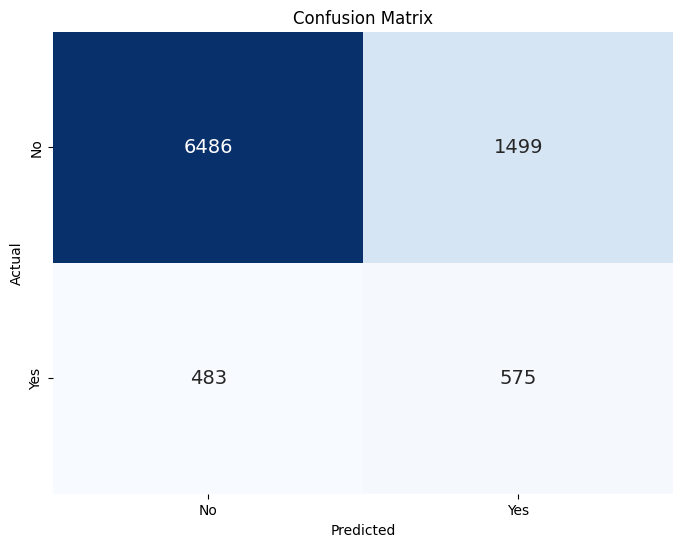

In [58]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'fontsize': 14}, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the labels for the axes
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

- High number of False Positives (1,433 cases)
   - Many non-subscribers were misclassified as subscribers.  
   - This could lead to wasted marketing efforts on uninterested customers.  

- Moderate number of False Negatives (485 cases) 
   - Some actual subscribers were missed, leading to lost business opportunities.  

### 3.3.3 ROC Curve

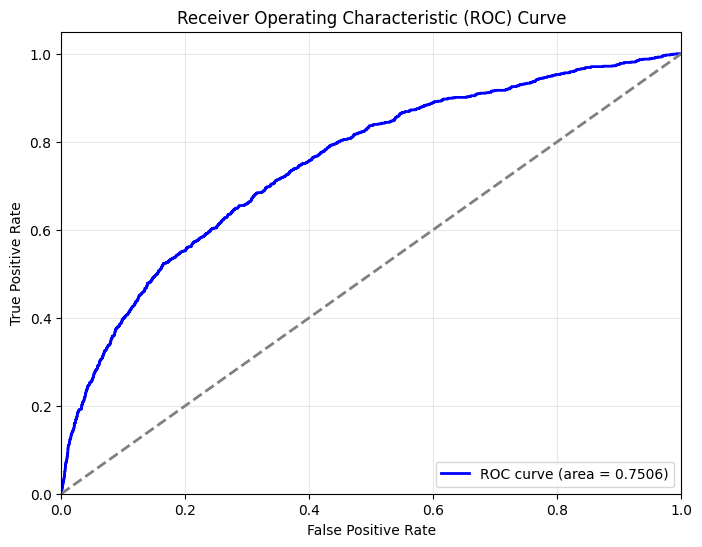

In [59]:
# Visualize the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

- The curve is not very steep at the beginning, suggesting that the model struggles with capturing true positives without also increasing false positives.
- The model effectively distinguishes between the classes, but the performance is not optimal. 

### 3.3.4 Precision-Recall Curve

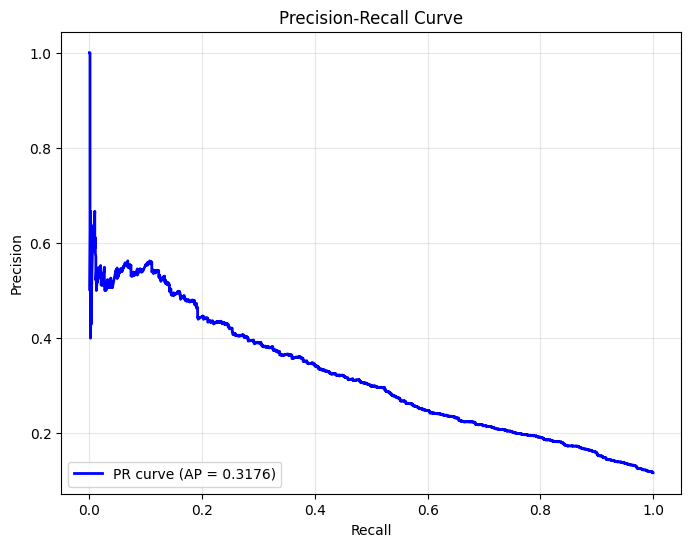

In [60]:
# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

- Low PR AUC score.
- The model struggles with precision-recall trade-offs, indicating that it is not highly effective in handling the imbalanced data.
- Precision drops as Recall increases. The sharp decline in precision suggests that as the model captures more positives (higher recall), it misclassifies a significant number of negatives.

## 3.4 Other Experimentations

### 3.4.1 Other Algorithms to Include in the Pipeline

In [61]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.decomposition import PCA

# Redefine the categorical pipeline to include imputer and encoder
categorical_features = df.drop(['duration', 'poutcome', 'default', 'loan', 'y'], axis=1) \
    .select_dtypes(exclude='number').columns
numeric_features = df.drop(['duration', 'poutcome', 'default', 'loan', 'y'], axis=1) \
    .select_dtypes(include='number').columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OneHotEncoder())
    # ('encoder', LabelEncoder())
])
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
    # ('scaler', MinMaxScaler())
])

# Creating a new preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('drop_columns', 'drop', ['duration', 'poutcome', 'default', 'loan'])
    ])

# Remove 'classifier__' prefix from the keys
best_params = {key.replace('classifier__', ''): value for key, value in best_params.items()}

# ImbPipeline with preprocessor, SMOTE, RandomForestClassifier, and others
imb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # ('pca', PCA(n_components=20)),  
    ('smote', SMOTE(random_state=42)),
    # ('undersampler', RandomUnderSampler(random_state=42)),
    # ('feature_selection', RFECV(estimator=RandomForestClassifier(random_state=42), step=1, cv=skf)),
    ('classifier', RandomForestClassifier(**best_params, random_state=42))
])

In [62]:
# Do the train-test split again
X = df.drop(columns='y')
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [63]:
# Fit the pipeline on the training data
imb_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = imb_pipeline.predict(X_test)
y_pred_proba = imb_pipeline.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba, pos_label='yes')

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

Accuracy: 0.8246
Precision: 0.3413
Recall: 0.5369
F1 Score: 0.4173
ROC AUC: 0.7722
PR AUC: 0.3712


Achieved a slight improvement of performance on the test set with the following changes:
- Used OneHotEncoder instead of LabelEncoder
- SMOTE within the pipeline, after preprocessing

### 3.4.2 Autoencoder

In [64]:
from keras.layers import Dense, Input
from keras.models import Model, Sequential
from keras import regularizers

In [65]:
# Preprocess the data with preprocessor
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Convert y_train to a NumPy array for comparison
y_train_array = y_train.to_numpy()

# Divide the yes and no samples
X_train_yes = X_train_preprocessed[y_train_array == 'yes'].astype('float32').toarray()
X_train_no = X_train_preprocessed[y_train_array == 'no'].astype('float32').toarray()

# Show the shape of the divided data
X_train_yes.shape, X_train_no.shape

((4231, 42), (31937, 42))

In [66]:
# Autoencoder model
# Input layer 
input_layer = Input(shape=(X_train_preprocessed.shape[1],))

# Encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(42, activation='relu')(encoded)

# Decoding part
decoded = Dense(42, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

# Output layer
output_layer = Dense(X_train_preprocessed.shape[1], activation='relu')(decoded)

In [67]:
# Create the autoencoder model
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [68]:
# Sample 4231 rows from the "no" class to match the "yes" class size
X_train_no_sampled = X_train_no[np.random.choice(X_train_no.shape[0], 4231, replace=False), :]
X_train_no_sampled.shape

(4231, 42)

In [69]:
# Fit the autoencoder model
autoencoder.fit(X_train_no_sampled, X_train_no_sampled, 
                batch_size = 16, epochs = 50, 
                shuffle = True, validation_split = 0.20);

Epoch 1/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3259 - val_loss: 0.3320
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3244 - val_loss: 0.3303
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3323 - val_loss: 0.3287
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3267 - val_loss: 0.3271
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3216 - val_loss: 0.3256
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3131 - val_loss: 0.3241
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3100 - val_loss: 0.3226
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3127 - val_loss: 0.3212
Epoch 9/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3075 - val_loss: 0.3198
Epoch 10/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2988 - val_loss: 0.3185
Epoch 11/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3072 - val_loss: 0.3171
Epoch 12/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [70]:
# Extract the hidden representation part of the autoencoder
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [71]:
# Get the hidden representation for the "yes" and "no" samples
no_hid_rep = hidden_representation.predict(X_train_no_sampled)
yes_hid_rep = hidden_representation.predict(X_train_yes)
no_hid_rep.shape, yes_hid_rep.shape

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


((4231, 42), (4231, 42))

In [72]:
# Combine the hidden representations as the new features and create the target variable
rep_x = np.append(no_hid_rep, yes_hid_rep, axis = 0)
y_n = np.zeros(no_hid_rep.shape[0])
y_y = np.ones(yes_hid_rep.shape[0])
rep_y = np.append(y_n, y_y)

In [73]:
# Split the data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = RandomForestClassifier().fit(train_x, train_y)
pred_y = clf.predict(val_x)

# Print results on evaluation metrics
print("Validation Results:")
print(f'Accuracy: {accuracy_score(val_y, pred_y):.4f}')
print(f'Precision: {precision_score(val_y, pred_y):.4f}')
print(f'Recall: {recall_score(val_y, pred_y):.4f}')
print(f'F1 Score: {f1_score(val_y, pred_y):.4f}')
print(f'ROC AUC: {roc_auc_score(val_y, pred_y):.4f}')
print(f'PR AUC: {average_precision_score(val_y, pred_y):.4f}')


Validation Results:
Accuracy: 0.6786
Precision: 0.7146
Recall: 0.6395
F1 Score: 0.6750
ROC AUC: 0.6804
PR AUC: 0.6451


In [74]:
# Calculate the results on the test set
pred_y_test = clf.predict(preprocessor.transform(X_test))
pred_y_test_proba = clf.predict_proba(preprocessor.transform(X_test))[:, 1]

# Transform pred_y_test back to original labels
pred_y_test = np.where(pred_y_test == 1, 'yes', 'no')

# Print results on evaluation metrics
print("Test Results:")
print(f'Accuracy: {accuracy_score(y_test, pred_y_test):.4f}')
print(f'Precision: {precision_score(y_test, pred_y_test, pos_label='yes'):.4f}')
print(f'Recall: {recall_score(y_test, pred_y_test, pos_label='yes'):.4f}')
print(f'F1 Score: {f1_score(y_test, pred_y_test, pos_label='yes'):.4f}')
print(f'ROC AUC: {roc_auc_score(y_test, pred_y_test_proba):.4f}')
print(f'PR AUC: {average_precision_score(y_test, pred_y_test_proba, pos_label='yes'):.4f}')

Test Results:
Accuracy: 0.4362
Precision: 0.1325
Recall: 0.6881
F1 Score: 0.2222
ROC AUC: 0.5646
PR AUC: 0.1398


Using autoenconders didn't really help the performance of the model

### 3.4.3 Separate Models

In [115]:
# Separate the data for those with or without previous record
df_with = df[df['pdays'] != -1]
df_without = df[df['pdays'] == -1]

# Print the proportion of `y` for each subset
print("Proportion of the Target Variable for Data with a Previous Record:")
display(df_with['y'].value_counts(normalize=True))
print("Proportion of the Target Variable for Data without a Previous Record:")
display(df_without['y'].value_counts(normalize=True))

Proportion of the Target Variable for Data with a Previous Record:


y
no    0.769
yes   0.231
Name: proportion, dtype: float64

Proportion of the Target Variable for Data without a Previous Record:


y
no    0.908
yes   0.092
Name: proportion, dtype: float64

In [116]:
# Print the shape for each
print("Shape of df_with: ", df_with.shape)
print("Shape of df_without: ", df_without.shape)

Shape of df_with:  (8257, 17)
Shape of df_without:  (36954, 17)


#### 3.4.3.1 Model for Existing Clients (With Previous Records)

In [117]:
# Separate the features from the target
X = df_with.drop('y', axis=1)
y = df_with['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [118]:
# Reusing the model pipeline from section 3.4.1

# Creating a preprocessor without poutcome at drop_columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('drop_columns', 'drop', ['duration', 'poutcome', 'default', 'loan'])
    ])

# Reinitializing the model pipeline (with SMOTE)
imb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=50, n_estimators=100, bootstrap=False, class_weight=None, 
                                          criterion='entropy', max_features='sqrt', min_samples_leaf=3, 
                                          min_samples_split=10,random_state=42)) # Base on best_params
])

# Without SMOTE
imb_pipeline_no_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=50, n_estimators=100, bootstrap=False, class_weight=None, 
                                          criterion='entropy', max_features='sqrt', min_samples_leaf=3, 
                                          min_samples_split=10,random_state=42)) # Base on best_params
])



##### 3.4.3.1.1 Baseline (No SMOTE)

In [119]:
# Fit the pipeline on the training data
imb_pipeline_no_smote.fit(X_train, y_train)

# Perform cross-validation
y_pred_cv = cross_val_predict(imb_pipeline_no_smote, X_train, y_train, cv=skf, method='predict')
y_pred_proba_cv = cross_val_predict(imb_pipeline_no_smote, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_train, y_pred_cv)
precision = precision_score(y_train, y_pred_cv, pos_label='yes')
recall = recall_score(y_train, y_pred_cv, pos_label='yes')
f1 = f1_score(y_train, y_pred_cv, pos_label='yes')
roc_auc = roc_auc_score(y_train, y_pred_proba_cv)
pr_auc = average_precision_score(y_train, y_pred_proba_cv, pos_label='yes')

# Print evaluation metrics
print("Results on the Cross Validation Set:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

Results on the Cross Validation Set:
Accuracy: 0.8285
Precision: 0.6631
Recall: 0.5217
F1 Score: 0.5839
ROC AUC: 0.8807
PR AUC: 0.6336


In [120]:
# Fit the pipeline on the training data
imb_pipeline_no_smote.fit(X_train, y_train)

# Make predictions on the test set
y_pred = imb_pipeline_no_smote.predict(X_test)
y_pred_proba = imb_pipeline_no_smote.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba, pos_label='yes')

# Print evaluation metrics
print("Results on the Test Set:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

Results on the Test Set:
Accuracy: 0.8329
Precision: 0.6688
Recall: 0.5459
F1 Score: 0.6012
ROC AUC: 0.8985
PR AUC: 0.6645


Model trained with only the data **with previous record** was able to achieved a PR AUC of **0.6645**, which is comparably better than before.

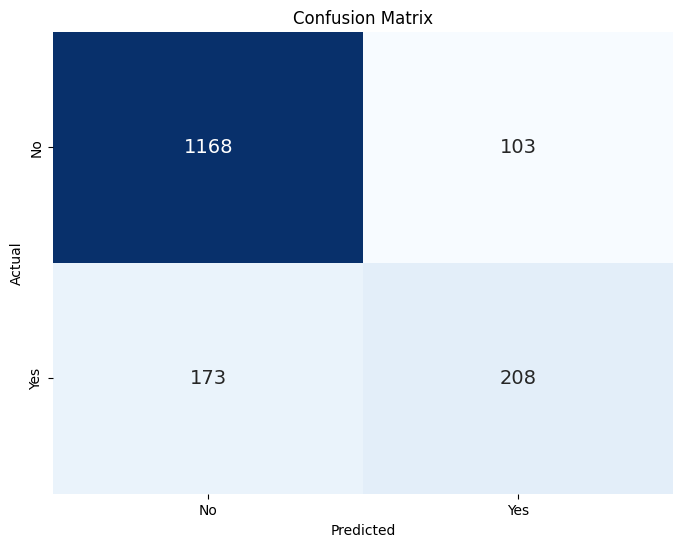

In [121]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'fontsize': 14}, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the labels for the axes
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

Moreover, the **True Positives** is now greater than the **False Positives**, making the model **more reliable** for predicting who will **actually subscribe** to the term deposit. Though, personally, I would still advise to further improve this model and minimize the False Positives and False Negatives.

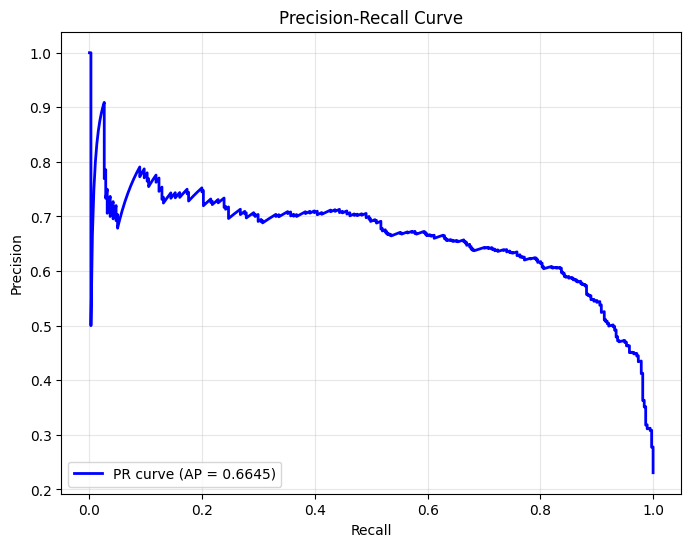

In [122]:
# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label='yes')

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba, pos_label='yes')

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

##### 3.4.3.1.2 Oversampled (with SMOTE)

In [102]:
# Fit the pipeline on the training data
imb_pipeline.fit(X_train, y_train)

# Perform cross-validation
y_pred_cv = cross_val_predict(imb_pipeline, X_train, y_train, cv=skf, method='predict')
y_pred_proba_cv = cross_val_predict(imb_pipeline, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_train, y_pred_cv)
precision = precision_score(y_train, y_pred_cv, pos_label='yes')
recall = recall_score(y_train, y_pred_cv, pos_label='yes')
f1 = f1_score(y_train, y_pred_cv, pos_label='yes')
roc_auc = roc_auc_score(y_train, y_pred_proba_cv)
pr_auc = average_precision_score(y_train, y_pred_proba_cv, pos_label='yes')

# Print evaluation metrics
print("Results on the Cross Validation Set:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

Results on the Cross Validation Set:
Accuracy: 0.8268
Precision: 0.6185
Recall: 0.6509
F1 Score: 0.6343
ROC AUC: 0.8792
PR AUC: 0.6193


In [103]:
# Fit the pipeline on the training data
imb_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = imb_pipeline.predict(X_test)
y_pred_proba = imb_pipeline.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba, pos_label='yes')

# Print evaluation metrics
print("Results on the Test Set:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

Results on the Test Set:
Accuracy: 0.8426
Precision: 0.6424
Recall: 0.7165
F1 Score: 0.6774
ROC AUC: 0.8966
PR AUC: 0.6491


Performance for oversampled data is actually **slightly worse** than the model trained with original data.

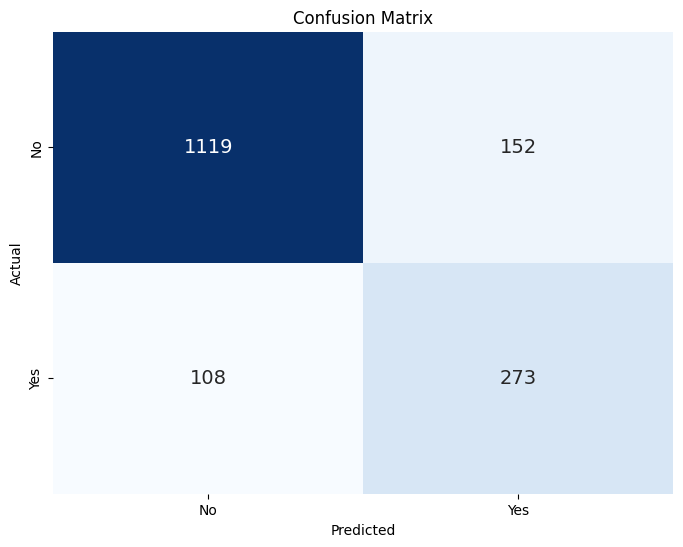

In [104]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'fontsize': 14}, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the labels for the axes
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

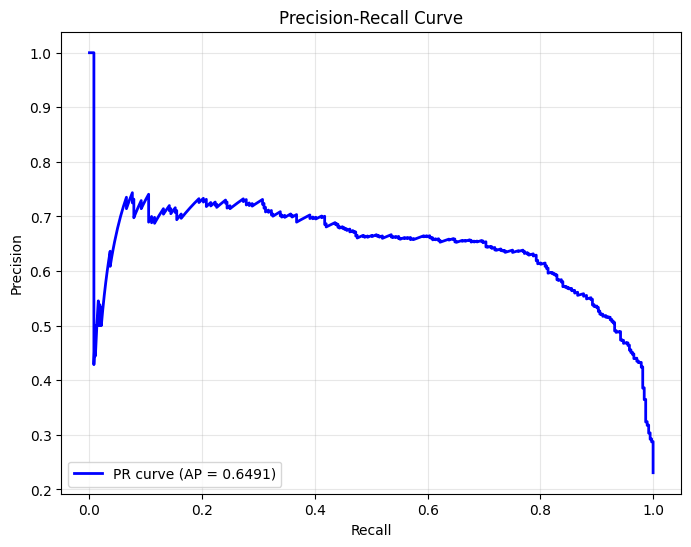

In [105]:
# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label='yes')

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba, pos_label='yes')

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

#### 3.4.3.2 Model for New Clients (Without a Previous Record)

In [123]:
# Separate the features from the target
X = df_without.drop(['y', 'pdays', 'poutcome', 'previous'] , axis=1) # Included the all previous record features in dropped columns
y = df_without['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [124]:
# Reusing the model pipeline from section 3.4.1

# Creating a preprocessor without poutcome at drop_columns
categorical_features = X_train.select_dtypes(exclude='number').columns
numeric_features = X_train.select_dtypes(include='number').columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('drop_columns', 'drop', ['duration', 'default', 'loan'])
    ])

# Reinitializing the model pipeline (with SMOTE)
imb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=50, n_estimators=100, bootstrap=False, class_weight=None, 
                                          criterion='entropy', max_features='sqrt', min_samples_leaf=3, 
                                          min_samples_split=10,random_state=42)) # Base on best_params
])

# Without SMOTE
imb_pipeline_no_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=50, n_estimators=100, bootstrap=False, class_weight=None, 
                                          criterion='entropy', max_features='sqrt', min_samples_leaf=3, 
                                          min_samples_split=10,random_state=42)) # Base on best_params
])



##### 3.4.3.2.1 Baseline (No SMOTE)

In [125]:
# Fit the pipeline on the training data
imb_pipeline_no_smote.fit(X_train, y_train)

# Perform cross-validation
y_pred_cv = cross_val_predict(imb_pipeline_no_smote, X_train, y_train, cv=skf, method='predict')
y_pred_proba_cv = cross_val_predict(imb_pipeline_no_smote, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_train, y_pred_cv)
precision = precision_score(y_train, y_pred_cv, pos_label='yes')
recall = recall_score(y_train, y_pred_cv, pos_label='yes')
f1 = f1_score(y_train, y_pred_cv, pos_label='yes')
roc_auc = roc_auc_score(y_train, y_pred_proba_cv)
pr_auc = average_precision_score(y_train, y_pred_proba_cv, pos_label='yes')

# Print evaluation metrics
print("Results on the Cross Validation Set:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

Results on the Cross Validation Set:
Accuracy: 0.9161
Precision: 0.6056
Recall: 0.2405
F1 Score: 0.3443
ROC AUC: 0.9329
PR AUC: 0.5375


In [126]:
# Fit the pipeline on the training data
imb_pipeline_no_smote.fit(X_train, y_train)

# Make predictions on the test set
y_pred = imb_pipeline_no_smote.predict(X_test)
y_pred_proba = imb_pipeline_no_smote.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba, pos_label='yes')

# Print evaluation metrics
print('Results on the Test Set: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

Results on the Test Set: 
Accuracy: 0.9165
Precision: 0.6136
Recall: 0.2393
F1 Score: 0.3443
ROC AUC: 0.9345
PR AUC: 0.5306


Similar to the model trained with previous record, the model centered only with those without previous record also has significant improvement, with PR AUC of **0.5306**, albeit not as good as the model with previous record.

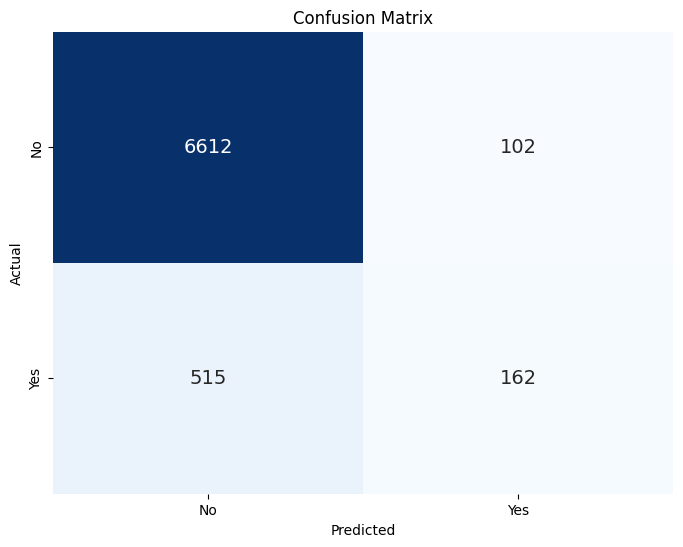

In [127]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'fontsize': 14}, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the labels for the axes
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

The latter half model is slightly worse, with almost equal number of **False Positives** and **True Positives**. I would personally recommend to further improve the model.

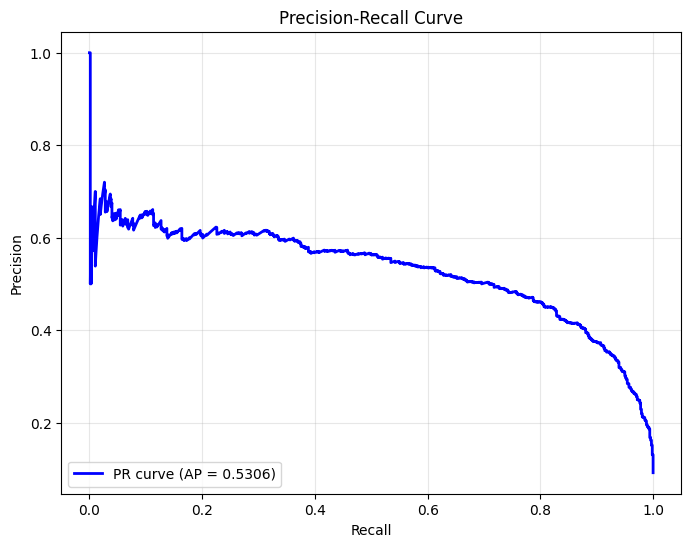

In [128]:
# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label='yes')

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba, pos_label='yes')

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

##### 3.4.3.2.2 Oversampled (with SMOTE)

In [111]:
# Fit the pipeline on the training data
imb_pipeline.fit(X_train, y_train)

# Perform cross-validation
y_pred_cv = cross_val_predict(imb_pipeline, X_train, y_train, cv=skf, method='predict')
y_pred_proba_cv = cross_val_predict(imb_pipeline, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_train, y_pred_cv)
precision = precision_score(y_train, y_pred_cv, pos_label='yes')
recall = recall_score(y_train, y_pred_cv, pos_label='yes')
f1 = f1_score(y_train, y_pred_cv, pos_label='yes')
roc_auc = roc_auc_score(y_train, y_pred_proba_cv)
pr_auc = average_precision_score(y_train, y_pred_proba_cv, pos_label='yes')

# Print evaluation metrics
print("Results on the Cross Validation Set:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

Results on the Cross Validation Set:
Accuracy: 0.9110
Precision: 0.5129
Recall: 0.5523
F1 Score: 0.5318
ROC AUC: 0.9298
PR AUC: 0.5172


In [112]:
# Fit the pipeline on the training data
imb_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = imb_pipeline.predict(X_test)
y_pred_proba = imb_pipeline.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba, pos_label='yes')

# Print evaluation metrics
print('Results on the Test Set: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')

Results on the Test Set: 
Accuracy: 0.9115
Precision: 0.5152
Recall: 0.5761
F1 Score: 0.5439
ROC AUC: 0.9301
PR AUC: 0.5069


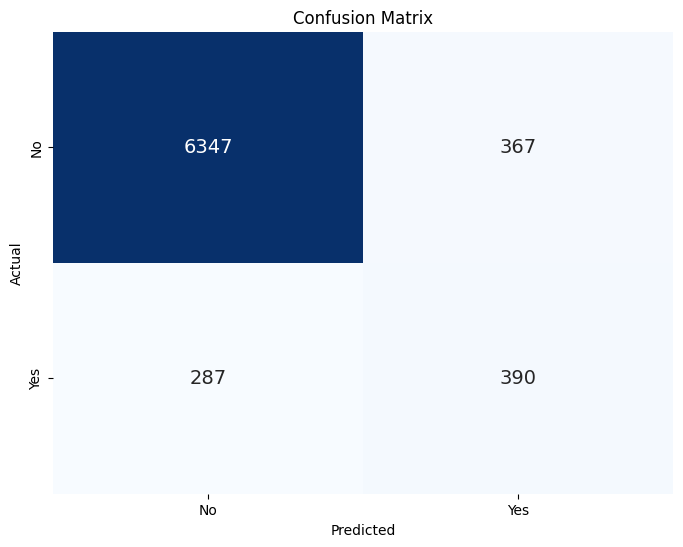

In [113]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'fontsize': 14}, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the labels for the axes
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

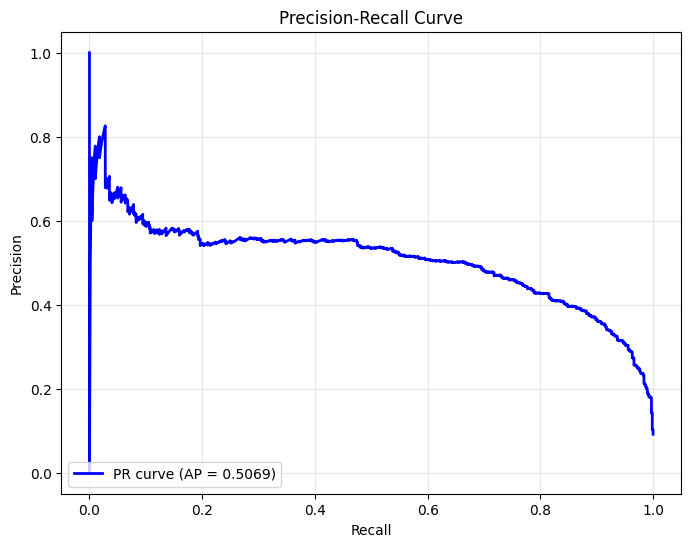

In [114]:
# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label='yes')

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba, pos_label='yes')

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

# 4. Conclusion

### Recommendation for the Next Marketing Campaign Based on Data Analysis and Predictive Modelling
- **Marital Status**: **Single** people have the highest acceptance rate. Due to the nature of their lifestyle, most of them have lesser expenses than Married and Divorced people, so they might be more amenable to accept the term deposit than others.
- **Job**: Managers and Technicians have the highest number of people who accepted the term deposit, and in terms of acceptance rate, Retired individuals and Students are the highest, while Managers are in 4th place. In terms of balance, **Retired** people and **Managers** also tend to have a higher balance. Hence, it would be recommended to slightly focus the resources and manpower to these two job categories.
- **Educational Attainment**: People who finished **Tertiary** education seems to have a higher balance and also a higher acceptance rate on the term deposity marketed to them.
- **Loans**: Majority of the people who accepted the term deposit seems to have **no Home and Personal loans**, while majority of the people who declined the term deposit have at least a home loan. Therefore, it might be a good idea to focus on the people who doesn't have any kinds of loan.
- **Balance**: People who subscribed to the term deposit tend to have a higher balance than those who didn't, so focusing on the people with **higher balance** might result to a higher acceptance rate in general.
- **Default**: Only ~1% of the people who subscribed to the term deposit have a default, and thus, it might be better to focus on people with **no default**.
- **Month of Subscription**: The term deposit has a surge of subscriber from **April to August**, which peaked at **May**. Focusing on these months might be a great idea.